In [1]:
from vtl.Readfile import Readfile
from spec_id import Analyze_LH_lwa, Error,Oldest_galaxy, Gen_spec, Stack,Median_model, \
    Median_w_Error,Median_w_Error_cont,Likelihood_contours,Gen_sim, Stack_posteriors, Linear_fit , Gen_grid
from astropy.table import Table
from astropy.io import fits
import astropy.units as u
from astropy.cosmology import Planck13, z_at_value
from scipy.interpolate import interp1d, interp2d
from scipy.ndimage import interpolation
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.axes_grid.inset_locator import inset_axes
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
from glob import glob
import seaborn as sea
import numpy as np
import pandas as pd
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
colors = [(0,i,i,i) for i in np.linspace(0,1,3)]
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.2, as_cmap=True)
pandas2ri.activate()

In [6]:
galDB = pd.read_pickle('../data/sgal_param_DB.pkl')
lzDB = galDB.query('hi_res_specz < 1.16')
mzDB = galDB.query('1.16 < hi_res_specz < 1.3')
mzDB = mzDB.query('ids != 14713 and ids != 38126')
hzDB = galDB.query('1.3 < hi_res_specz < 1.45')
uhzDB = galDB.query('1.45 < hi_res_specz')

metal=np.arange(0.002,0.031,0.001)
age=np.arange(.5,6.1,.1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [60]:
galDB

,gids,ids,ra,dec,hi_res_specz,lmass,tau,Z_f,Z_-_sig_f,Z_+_sig_f,...,tx_+_sig_lwa,Zx_lwa,Zx_-_sig_lwa,Zx_+_sig_lwa,Z_lwa,Z_-_sig_lwa,Z_+_sig_lwa,t_lwa,t_-_sig_lwa,t_+_sig_lwa
43,n14713,14713,189.236333,62.214608,1.232,10.56,8.78,0.018,0.011,0.008,...,0.573146,0.015916,0.010156,0.009539,0.016,0.010,0.009,2.6,0.656,0.479
49,n16758,16758,189.162357,62.224840,1.014,10.83,0.00,0.020,0.001,0.002,...,0.286573,0.020124,0.001403,0.002918,0.021,0.002,0.002,5.3,0.579,0.226
50,n17070,17070,189.268086,62.226445,1.192,10.92,8.48,0.011,0.003,0.004,...,0.595190,0.010305,0.002581,0.004545,0.011,0.003,0.004,2.4,0.478,0.580
58,n19442,19442,189.123036,62.237460,1.101,10.10,8.90,0.015,0.009,0.010,...,1.080160,0.013952,0.008305,0.010549,0.014,0.008,0.011,2.7,0.811,1.063
61,n21156,21156,189.239409,62.247548,1.251,11.16,8.30,0.020,0.005,0.004,...,0.495992,0.019900,0.004545,0.004208,0.020,0.005,0.004,2.2,0.432,0.405
62,n21427,21427,189.368121,62.247344,1.514,10.73,8.48,0.019,0.010,0.007,...,0.584168,0.017880,0.008641,0.008305,0.018,0.009,0.008,2.4,0.632,0.547
69,n23435,23435,189.338306,62.256571,1.134,10.27,8.60,0.014,0.006,0.009,...,0.870741,0.014064,0.006172,0.009034,0.015,0.007,0.008,3.4,0.762,0.847
86,n32566,32566,189.161280,62.307577,1.150,10.61,8.70,0.020,0.008,0.006,...,0.551102,0.019563,0.007743,0.006902,0.020,0.008,0.006,2.1,0.696,0.472
96,n34694,34694,189.147840,62.323647,1.145,10.94,8.30,0.015,0.006,0.005,...,0.958918,0.014345,0.004882,0.005667,0.015,0.006,0.005,2.8,0.459,0.963
107,n37686,37686,189.274474,62.360820,1.258,10.89,8.48,0.016,0.003,0.004,...,0.573146,0.015355,0.002357,0.004265,0.016,0.003,0.004,3.4,0.486,0.517


# Mass histogram


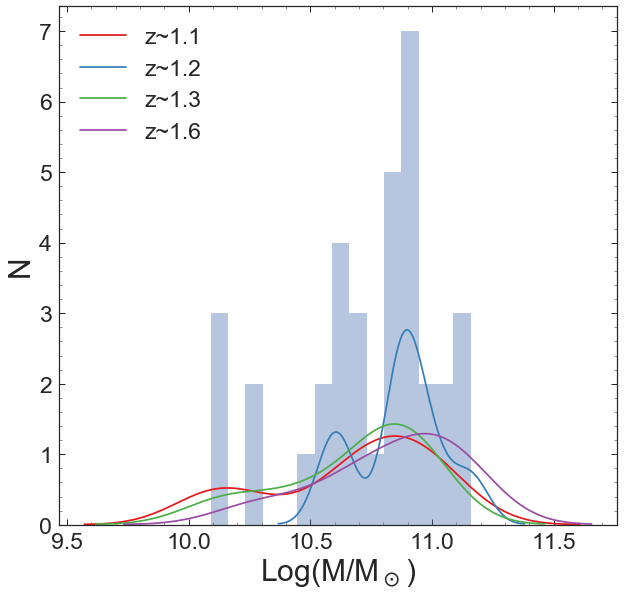

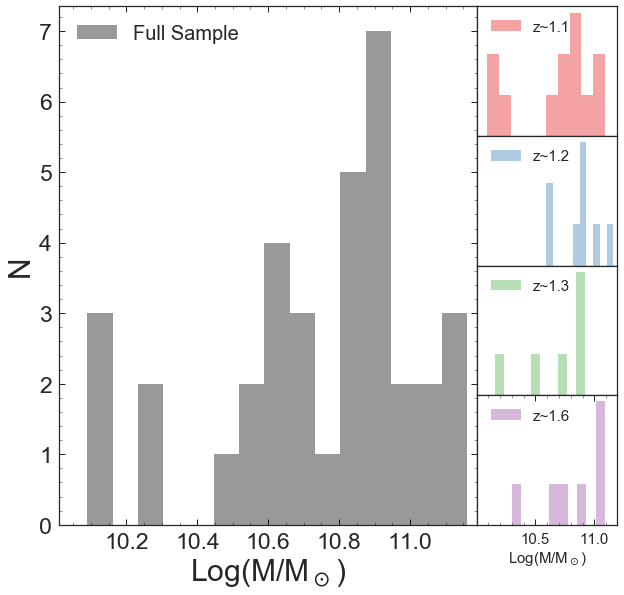

In [47]:
%matplotlib inline
plt.figure(figsize=[10,10])
sea.distplot(galDB['lmass'],kde=False,bins=15)
sea.distplot(lzDB['lmass'],color='#e41a1c',hist=False,label='z~1.1')
sea.distplot(mzDB['lmass'],color='#377eb8',hist=False,label='z~1.2')
sea.distplot(hzDB['lmass'],color='#4daf4a',hist=False,label='z~1.3')
sea.distplot(uhzDB['lmass'],color='#984ea3',hist=False,label='z~1.6')
# plt.axis([0,2.5,.5,2.5])
plt.legend(loc=2,fontsize=23)
plt.xlabel('Log(M/M$_\odot$)',fontsize=30)
plt.ylabel('N',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.gcf().subplots_adjust(bottom=0.16)
# plt.show()
plt.savefig('../plots/mass_hist1.pdf',bbox_inches = 'tight')
plt.close

gs = gridspec.GridSpec(4,2,width_ratios=[3,1],wspace=0,hspace=0)

plt.figure(figsize=[10,10])
plt.subplot(gs[:,:-1])
sea.distplot(galDB['lmass'],kde=False,bins=15,color='k',label = 'Full Sample')
plt.xlim(10.01,11.19)
plt.xlabel('Log(M/M$_\odot$)',fontsize=30)
plt.ylabel('N',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.legend(loc=2,fontsize=20)


plt.subplot(gs[0,1])
sea.distplot(lzDB['lmass'],color='#e41a1c',kde=False,label='z~1.1',bins=10)
plt.yticks([])
plt.xticks([])
plt.xlim(10.01,11.19)
plt.legend(loc=2,fontsize=15)

plt.subplot(gs[1,1])
sea.distplot(mzDB['lmass'],color='#377eb8',kde=False,label='z~1.2',bins=10)
plt.yticks([])
plt.xticks([])
plt.xlim(10.01,11.19)
plt.legend(loc=2,fontsize=15)

plt.subplot(gs[2,1])
sea.distplot(hzDB['lmass'],color='#4daf4a',kde=False,label='z~1.3',bins=10)
plt.yticks([])
plt.xticks([])
plt.xlim(10.01,11.19)
plt.legend(loc=2,fontsize=15)

plt.subplot(gs[3,1])
sea.distplot(uhzDB['lmass'],color='#984ea3',kde=False,label='z~1.6',bins=10)
plt.yticks([])
plt.xlim(10.01,11.19)



plt.legend(loc=2,fontsize=15)
plt.xlabel('Log(M/M$_\odot$)',fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.gcf().subplots_adjust(bottom=0.16)
# plt.show()
plt.savefig('../plots/mass_hist2.pdf',bbox_inches = 'tight')

# SN vs mass and redshift

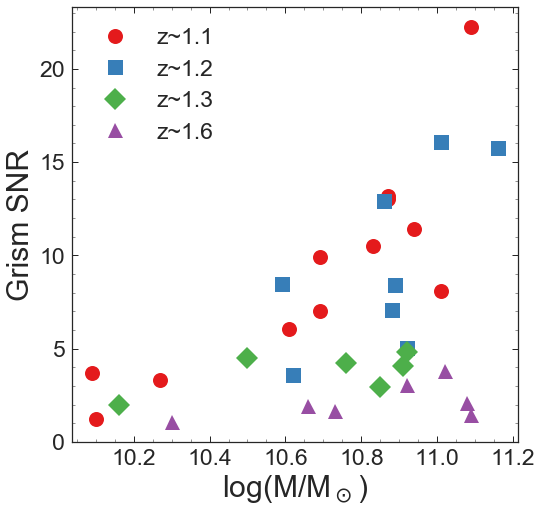

In [69]:
###PLOT
%matplotlib inline
#'#e41a1c' '#377eb8' '#4daf4a' '#984ea3'
#'o','s','D','^'
plt.figure(figsize=[8,8])
plt.plot(lzDB['lmass'],lzDB['SN'],'o', ms=15, color='#e41a1c', label = 'z~1.1')
plt.plot(mzDB['lmass'],mzDB['SN'],'s', ms=15,color='#377eb8', label = 'z~1.2')
plt.plot(hzDB['lmass'],hzDB['SN'],'D', ms=15,color='#4daf4a', label = 'z~1.3')
plt.plot(uhzDB['lmass'],uhzDB['SN'],'^', ms=15,color='#984ea3', label = 'z~1.6')
# sea.distplot(galDB['lmass'],bins=12,kde=False)
plt.legend(loc=2,fontsize=23)
plt.xlabel('log(M/M$_\odot$)',fontsize=30)
plt.ylabel('Grism SNR',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.savefig('../plots/sn_v_mass.pdf',bbox_inches = 'tight')

# Photo z - Grism z

In [108]:
#DATA

photz =np.array([1.13, 0.99, 1.23, 1.01, 1.2, 1.48, 1.09, 1.18, 1.09,
        1.27, 1.26, 1.23, 1.18, 1.66, 1.08, 1.05, 1.08, 1.36,
        1.16, 1.65, 1.19, 1.24, 1.51, 1.34, 1.72, 1.64, 1.69,
        1.04, 1.67, 1.08, 1.05, 1.32, 1.4 , 1.1, 1.14])

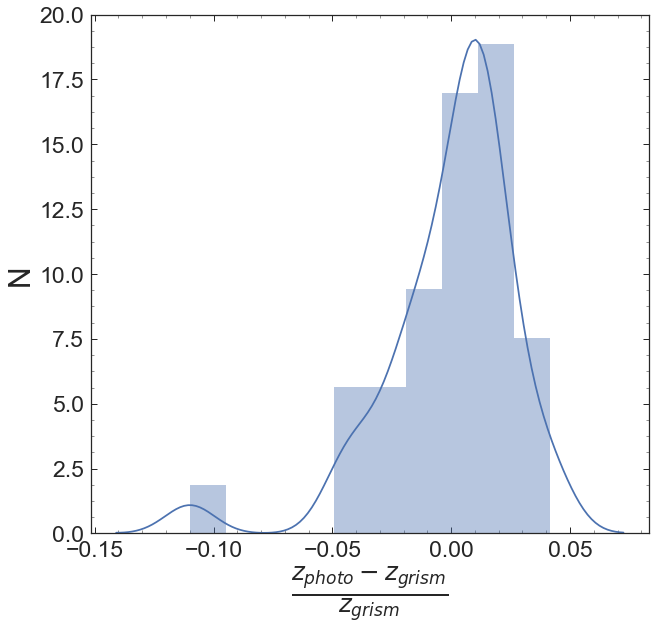

In [110]:
#PLOT
%matplotlib inline

plt.figure(figsize=[10,10])
sea.distplot((photz - galDB['hi_res_specz'])/(1+galDB['hi_res_specz']) ,kde=True,bins=10)
plt.legend(loc=2,fontsize=23)
plt.xlabel('$\\frac{z_{photo}-z_{grism}}{z_{grism}}$',fontsize=35)
plt.ylabel('N',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.gcf().subplots_adjust(bottom=0.16)
# plt.show()
plt.savefig('../plots/photo_vs_grism_z.pdf',bbox_inches = 'tight')

# UVJ plot

In [9]:
###DATA 
uvjDB = pd.read_pickle('../data/uvj_db.pkl')
uvjSDB = uvjDB[uvjDB['IN_SAMP'] == True]
uvjSDB = uvjSDB.query('ra != 189.236333 and ra != 189.284502')

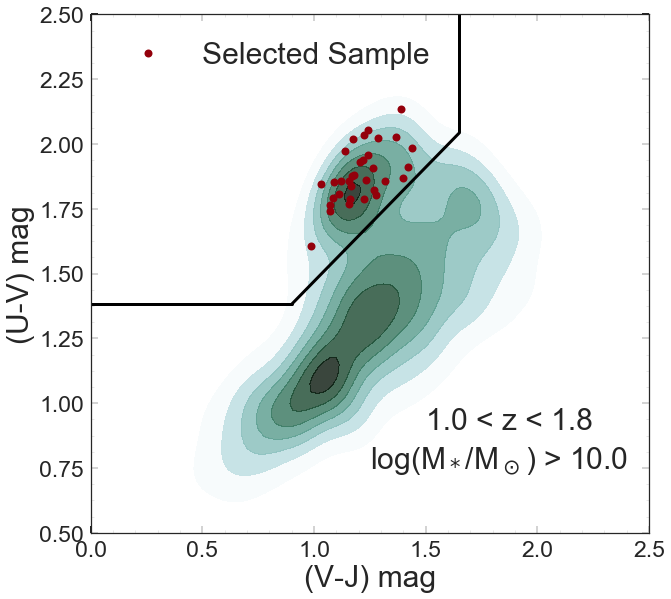

In [17]:
###PLOTS
%matplotlib inline

# plt.figure(figsize=[10,10])
# plt.plot(uvjDB['(V-J)'],uvjDB['(U-V)'],'o',color='#127794', alpha=.5,ms=3, label = 'Star Forming')
# plt.plot(uvjDB['(V-J)'][uvjDB['Q/S'] == 'q'],uvjDB['(U-V)'][uvjDB['Q/S'] == 'q'],'o',color='#E81524', alpha=.5,ms=3, label = 'Quiscent')
# plt.plot(uvjDB['(V-J)'][uvjDB['IN_SAMP'] == True],uvjDB['(U-V)'][uvjDB['IN_SAMP'] == True],'d',color='#93000B',ms=10, label = 'Selected Sample')
# plt.plot([0,.9],[1.382,1.382],'k',lw=.9)
# plt.plot([1.65,1.65],[2.045,2.5],'k',lw=.9)
# plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=.9)
# plt.axis([0,2.5,.5,2.5])
# plt.legend(loc=2,fontsize=23)
# plt.xlabel('(V-J)',fontsize=30)
# plt.ylabel('(U-V)',fontsize=30)
# plt.tick_params(axis='both', which='major', labelsize=23)
# plt.minorticks_on()
# plt.gcf().subplots_adjust(bottom=0.16)
# # plt.show()
# plt.savefig('../plots/uvj_plot_6-28.png')
# plt.close()

plt.figure(figsize=[10,10])
sea.kdeplot(uvjDB['(V-J)'],uvjDB['(U-V)'],n_levels = 7,alpha = .8,shade=True,cmap=cmap,kernel= 'epa',zorder=1)
plt.plot(uvjSDB['(V-J)'],uvjSDB['(U-V)'],'o',color='#93000B',ms=8, label = 'Selected Sample')
plt.plot([0,.9],[1.382,1.382],'k',lw=.9,linewidth=3)
plt.plot([1.65,1.65],[2.045,2.5],'k',lw=.9,linewidth=3)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=.9,linewidth=3)
plt.axis([0,2.5,.5,2.5])
plt.legend(fontsize=30)
plt.text(1.5,0.90,'1.0 < z < 1.8', fontsize = 30)
plt.text(1.25,0.75,'log(M$_*$/M$_\odot$) > 10.0', fontsize = 30)
plt.xlabel('(V-J) mag',fontsize=30)
plt.ylabel('(U-V) mag',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=23,length = 7, width=2)
plt.minorticks_on()
plt.gcf().subplots_adjust(bottom=0.16)
# plt.show()
plt.savefig('../plots/uvj_kde_plot_8-27.pdf',bbox_inches = 'tight')
# plt.close()

#Example Spectra and Best Fit

In [3]:
###DATA
spec = Gen_spec(galDB['gids'][61], galDB['hi_res_specz'][61],delayed=True,maxwv=11400)
bftau = Median_model(galDB['gids'][61], galDB['hi_res_specz'][61], galDB['Z_lwa'][61], galDB['t_lwa'][61], tau)
spec.Sim_spec(galDB['Z_lwa'][61],galDB['t_lwa'][61],bftau)

The following tasks in the stwcs.gui package can be run with TEAL:
     apply_headerlet          archive_headerlet          attach_headerlet     
     delete_headerlet         extract_headerlet         headerlet_summary     
    restore_headerlet             updatewcs              write_headerlet


../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat
../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename co

/Users/Vince.ec/anaconda2/envs/astroconda/lib/python2.7/site-packages/grizli/model.py:496: RuntimeWarning: invalid value encountered in divide
  self.optimal_profile = m/m.sum(axis=0)


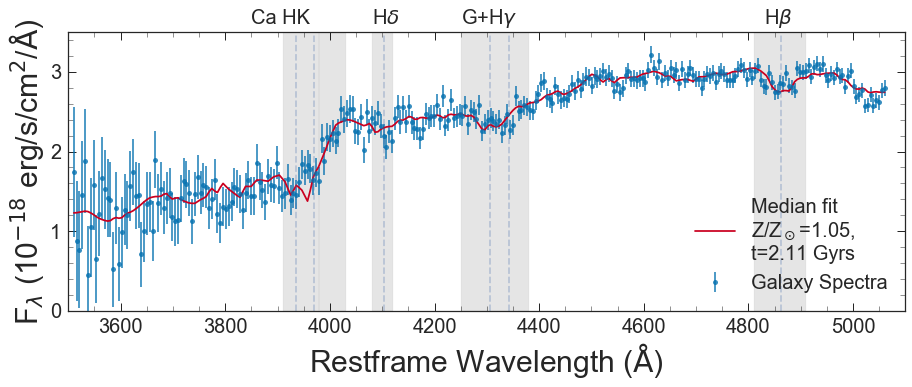

In [67]:
###PLOT
%matplotlib inline

sea.set_style( {"xtick.major.size": 8, "ytick.major.size": 8,
                "xtick.minor.size": 5, "ytick.minor.size": 5})
plt.figure(figsize=(15,6))
plt.errorbar(spec.gal_wv_rf,spec.gal_fl*1E18,spec.gal_er*1E18,fmt='o',color='#0571b0', alpha = .8,ms=5,label = 'Galaxy Spectra')
plt.plot(spec.gal_wv_rf,spec.fl*1E18, color='#ca0020',
         label='Median fit\nZ/Z$_\odot$=%s,\nt=%s Gyrs' % (np.round(galDB['Zx_lwa'][61]/0.019,2),
                                                           np.round(galDB['tx_lwa'][61],2)))
plt.axvline(3934.777,linestyle='--', alpha=.3)
plt.axvline(3969.588,linestyle='--', alpha=.3)
plt.axvline(4102.89,linestyle='--', alpha=.3)
plt.axvline(4305.61,linestyle='--', alpha=.3)
plt.axvline(4341.68,linestyle='--', alpha=.3)
plt.axvline(4862.68,linestyle='--', alpha=.3)
plt.axvline(5176.7,linestyle='--', alpha=.3)
plt.axvspan(3910, 3980, color='k', alpha=.1)
plt.axvspan(3980, 4030, color='k', alpha=.1)
plt.axvspan(4080, 4120, color='k', alpha=.1)
plt.axvspan(4250, 4380, color='k', alpha=.1)
plt.axvspan(4810, 4910, color='k', alpha=.1)
plt.axvspan(5120, 5240, color='k', alpha=.1)
plt.text(3850,3.6,'Ca HK',fontsize=20)
plt.text(4080,3.6,'H$\delta$',fontsize=20)
plt.text(4250,3.6,'G+H$\gamma$',fontsize=20)
plt.text(4830,3.6,'H$\\beta$',fontsize=20)
# plt.text(5160,5.6,'Mgb',fontsize=25)
plt.xlim(3500,5100)
plt.ylim(0,3.5)
plt.ylabel('F$_\lambda$ (10$^{-18}$ erg/s/cm$^2$/$\\rm \AA$)',size=30)
plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.gcf().subplots_adjust(bottom=0.235)
plt.legend(loc=4,fontsize=20)
plt.minorticks_on()
# plt.show()
plt.savefig('../plots/n21156_spec_12-13.pdf',bbox_inches = 'tight')
# plt.close()

#Grizli Example

In [87]:
###DATA
spec = Gen_sim(galDB['gids'][61], galDB['hi_res_specz'][61],galDB['Z_lwa'][61],galDB['t_lwa'][61],8.48,maxwv=11400)
spec.Sim_spec(galDB['Z_lwa'][61],galDB['t_lwa'][61],8.48)
spec.RM_sim_spec_cont()
spec.Perturb_both()
print galDB['Z_lwa'][61],galDB['t_lwa'][61]
wv,fl = np.load('../../../fsps_models_for_fit/fsps_spec/m0.02_a1.7_dt8.48_spec.npy')

../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat
0.02 1.7


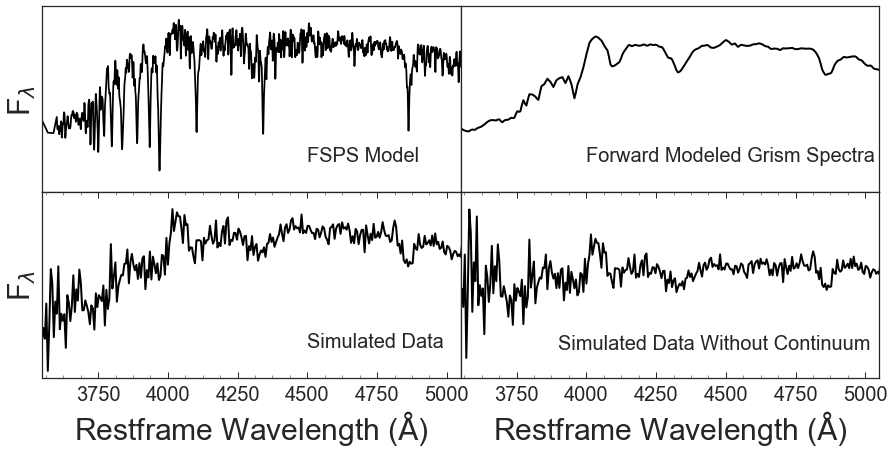

In [105]:
###PLOT###PLOT
%matplotlib inline

gs = gridspec.GridSpec(2,2,wspace=0,hspace=0)

plt.figure(figsize=(15,8))
plt.subplot(gs[0,0])
plt.plot(wv,fl*1.9E4, color='k')
plt.xlim(3550,5050)
plt.ylim(0.5,3.5)
plt.xticks([])
plt.yticks([])
plt.ylabel('F$_\lambda$',size=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.gcf().subplots_adjust(bottom=0.235)
plt.text(4500,1,'FSPS Model',fontsize=20)
plt.minorticks_on()

plt.subplot(gs[0,1])
plt.plot(spec.gal_wv_rf,spec.fl*1E18, color='k', linewidth=2)
plt.xlim(3550,5050)
plt.ylim(0.5,3.5)
plt.xticks([])
plt.yticks([])
plt.tick_params(axis='both', which='major', labelsize=20)
plt.gcf().subplots_adjust(bottom=0.235)
plt.text(4000,1,'Forward Modeled Grism Spectra',fontsize=20)
plt.minorticks_on()

plt.subplot(gs[1,0])
plt.plot(spec.gal_wv_rf,spec.flx_err*1E18, color='k',linewidth=2)
plt.xlim(3550,5050)
plt.ylim(0.5,3.5)
plt.yticks([])
plt.ylabel('F$_\lambda$',size=30)
plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.gcf().subplots_adjust(bottom=0.235)
plt.text(4500,1,'Simulated Data',fontsize=20)
plt.minorticks_on()

plt.subplot(gs[1,1])
plt.plot(spec.gal_wv_rf,spec.nc_flx_err, color='k', linewidth=2)
plt.xlim(3550,5050)
plt.ylim(0.25,1.5)
plt.yticks([])
plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.gcf().subplots_adjust(bottom=0.235)
plt.text(3900,.44,'Simulated Data Without Continuum',fontsize=20)
plt.minorticks_on()

# plt.show()
plt.savefig('../plots/ex_gr_sim_12-6.pdf',bbox_inches = 'tight')
# plt.close()

#Simulation Example

In [19]:
###Data 
spec = Gen_sim(galDB['gids'][220],galDB['hi_res_specz'][220],0.019,2.0,8.0,maxwv=11400)
spec.Perturb_flux()
lines = [3934,3969,4102,4305,4341,4862,5176]
regions = [[3910, 3980],[3980, 4030],[4080, 4120],[4250, 4380],[4810, 4910],[5120, 5240]]
txlines = [3900,4070,4250,4830,5160]
text = ['Ca HK','H$\delta$','G+H$\gamma$','H$\\beta$','Mgb']

The following tasks in the stwcs.gui package can be run with TEAL:
     apply_headerlet          archive_headerlet          attach_headerlet     
     delete_headerlet         extract_headerlet         headerlet_summary     
    restore_headerlet             updatewcs              write_headerlet


../data/galaxy_flts/s39170_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39170_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39170_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39170_flt: save ../data/galaxy_flts/s39170_flt.detect_seg.fits, ../data/galaxy_flts/s39170_flt.detect.cat


/Users/Vince.ec/anaconda2/envs/astroconda/lib/python2.7/site-packages/grizli/model.py:496: RuntimeWarning: invalid value encountered in divide
  self.optimal_profile = m/m.sum(axis=0)


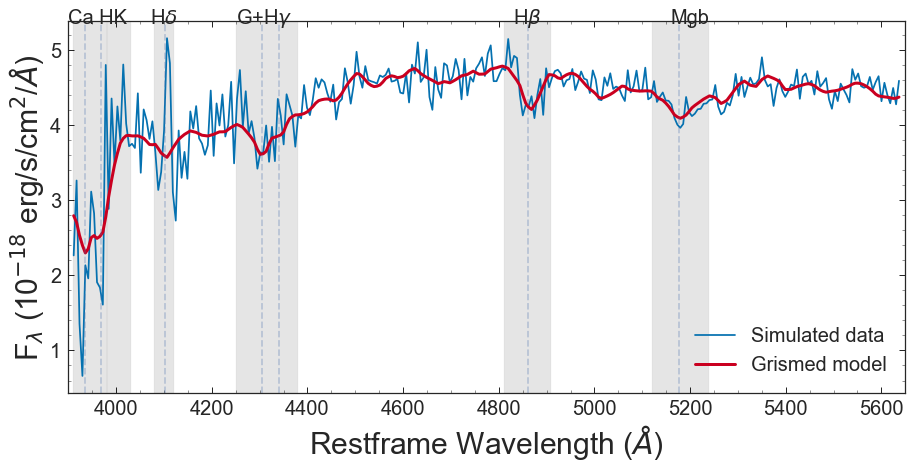

In [22]:
###Plot
%matplotlib inline
plt.figure(figsize=(15,8))
plt.plot(spec.gal_wv_rf,spec.flx_err*1E18, color='#0571b0',label='Simulated data')
plt.plot(spec.gal_wv_rf,spec.fl*1E18, color='#ca0020',label='Grismed model',linewidth = 3)
[plt.axvline(U,linestyle='--', alpha=.3) for U in lines]   
[plt.axvspan(U[0], U[1], color='k', alpha=.1) for U in regions]   
[plt.text(txlines[U],5.35,text[U],fontsize=20) for U in range(len(txlines))]   
plt.xlim(3900,5650)
plt.ylabel('F$_\lambda$ (10$^{-18}$ erg/s/cm$^2$/$\AA$)',size=30)
plt.xlabel('Restframe Wavelength ($\AA$)',size=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.gcf().subplots_adjust(bottom=0.235)
plt.legend(loc=4,fontsize=20)
plt.minorticks_on()
# plt.show()
# plt.savefig('../plots/simulated_data_10-26.pdf',bbox_inches = 'tight')
# plt.close()

#Example Posterior

In [18]:
###DATA
P = np.load('../chidat/n21156_dtau_tZ_pos_lwa.npy')
t,Pt = np.load('../chidat/n21156_dtau_t_pos_lwa.npy')
Z,PZ = np.load('../chidat/n21156_dtau_Z_pos_lwa.npy')
onesig,twosig = Likelihood_contours(age,metal,P)
levels = np.array([twosig,onesig])

P2,PZ2,Pt2 = Analyze_LH_lwa('../chidat/n21156_dtau_chidata.npy',galDB['hi_res_specz'][61],
                          metal,age,tau,age_conv='../data/light_weight_scaling_3.npy')

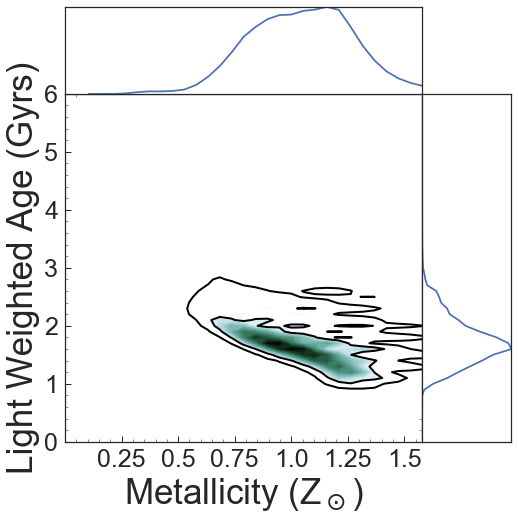

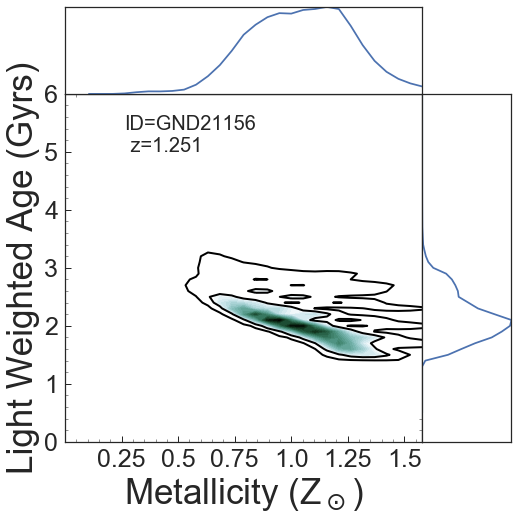

In [20]:
%matplotlib inline

###PLOT
gs = gridspec.GridSpec(2,2,height_ratios=[1,4],width_ratios=[4,1],hspace=0,wspace=0)
plt.figure(figsize=[8,8])

plt.subplot(gs[2])
plt.contour(M,A,P,levels,colors='k',linewidths=2)
plt.contourf(M,A,P,40,cmap=cmap)
plt.axis([0,0.03,0,6])
plt.xlabel('Metallicity (Z$_\odot$)',size=35)
plt.ylabel('Light Weighted Age (Gyrs)',size=35)
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([ 0.00475,  0.0095 ,  0.01425,  0.019  ,  0.02375,  0.0285 ],[0.25,.5,0.75,1.0,1.25,1.5])

plt.subplot(gs[0])
plt.plot(Z,PZ)
plt.xticks([])
plt.yticks([])
plt.xlim(0,0.03)
plt.ylim(0,max(PZ))

plt.subplot(gs[3])
plt.plot(Pt,t)
plt.xticks([])
plt.yticks([])
plt.ylim(0,6)
plt.xlim(0,max(Pt))

plt.show()
# plt.savefig('../plots/n21156_lh_10-17.pdf',bbox_inches = 'tight')
plt.close()

gs = gridspec.GridSpec(2,2,height_ratios=[1,4],width_ratios=[4,1],hspace=0,wspace=0)
plt.figure(figsize=[8,8])

plt.subplot(gs[2])
plt.contour(M,A,P2,levels,colors='k',linewidths=2)
plt.contourf(M,A,P2,40,cmap=cmap)
plt.axis([0,0.03,0,6])
plt.xlabel('Metallicity (Z$_\odot$)',size=35)
plt.ylabel('Light Weighted Age (Gyrs)',size=35)
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([ 0.00475,  0.0095 ,  0.01425,  0.019  ,  0.02375,  0.0285 ],[0.25,.5,0.75,1.0,1.25,1.5])
plt.text(.005,5,'ID=GND21156\n z=1.251', fontsize=20)

plt.subplot(gs[0])
plt.plot(Z,PZ2)
plt.xticks([])
plt.yticks([])
plt.xlim(0,0.03)
plt.ylim(0,max(PZ2))

plt.subplot(gs[3])
plt.plot(Pt2,t)
plt.xticks([])
plt.yticks([])
plt.ylim(0,6)
plt.xlim(0,max(Pt2))

# plt.show()
plt.savefig('../plots/n21156_lh_12-13.pdf',bbox_inches = 'tight')
# plt.close()

# Spectra and Photometry

In [52]:
###DATA 
phot_db = pd.read_pickle('../data/phot_db.pkl')
smpDB = pd.read_pickle('../data/sim_meas_phot.pkl')
spec = Gen_spec('n21156', 1.251)
Clam = 3E18 / phot_db['eff_wv'] **2 * 10**((-1.1)/2.5-29)
if max(phot_db['n21156']*1E18 * Clam) > max(spec.gal_fl*1E18):
    ymax = max(phot_db['n21156']*1E18 * Clam)
else:
    ymax = max(spec.gal_fl*1E18)

No TEAL-based tasks available for this package!
../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat


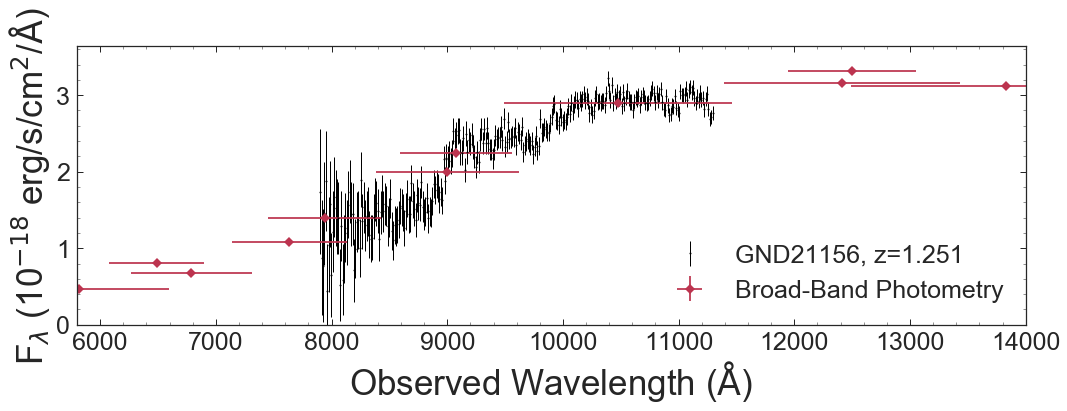

In [53]:
###PLOT
%matplotlib inline    

plt.figure(figsize=[17,6])
plt.errorbar(spec.gal_wv,spec.gal_fl * 1E18,spec.gal_er * 1E18,fmt='o',color = 'k', ms=2,elinewidth=1,label = 'GND21156, z=1.251')

# plt.plot(smpDB['f850-effwv'][61], smpDB['sim-f850'][61] * 1E18,'d',color='#2B4CFF',ms=15)
# plt.plot(smpDB['f098-effwv'][61], smpDB['sim-f098'][61] * 1E18,'d',color='#2B4CFF',ms=15)
# plt.plot(smpDB['f105-effwv'][61], smpDB['sim-f105'][61] * 1E18,'d',color='#2B4CFF',ms=15)

plt.errorbar(phot_db['eff_wv'],phot_db['n21156'] * Clam *1E18 ,phot_db['n21156_err'] * Clam *1E18,
             phot_db['fwhm']/2 ,color='#BC344F',fmt='D',label='Broad-Band Photometry')
plt.ylim(0,ymax*1.1)
plt.xlim(5800,14000)
plt.minorticks_on()
plt.ylabel('F$_\lambda$ (10$^{-18}$ erg/s/cm$^2$/$\\rm \AA$)',size=35)
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel('Observed Wavelength ($ \\rm \AA$)',size=35)
plt.legend(loc=4,fontsize = 25)
plt.gcf().subplots_adjust(bottom=0.235)
plt.savefig('../plots/n21156_phot_spec.pdf',bbox_inches = 'tight')
# plt.show()
# plt.close()

In [54]:
###DATA 
# phot_db = pd.read_pickle('../data/phot_db.pkl').drop('s_F105W')
phot_db = pd.read_pickle('../data/phot_db.pkl')
spec = Gen_spec('s39170', 1.022)
Clam = 3E18 / phot_db['eff_wv'] **2 * 10**((-1.1)/2.5-29)
if max(phot_db['s39170']*1E18 * Clam) > max(spec.gal_fl*1E18):
    ymax = max(phot_db['s39170']*1E18 * Clam)
else:
    ymax = max(spec.gal_fl*1E18)

../data/galaxy_flts/s39170_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39170_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39170_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39170_flt: save ../data/galaxy_flts/s39170_flt.detect_seg.fits, ../data/galaxy_flts/s39170_flt.detect.cat


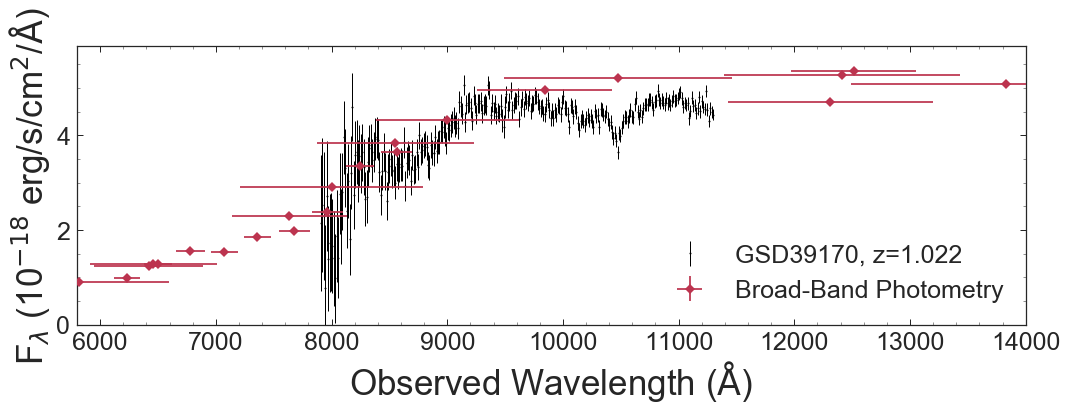

In [55]:
###PLOT
%matplotlib inline    

plt.figure(figsize=[17,6])
plt.errorbar(spec.gal_wv,spec.gal_fl * 1E18,spec.gal_er * 1E18 * 1.07,fmt='o',color = 'k', ms=2,elinewidth=1,label = 'GSD39170, z=1.022')

# plt.plot(smpDB['f850-effwv'][220], smpDB['sim-f850'][220] * 1E18 * 1.07,'d',color='#2B4CFF',ms=15)
# plt.plot(smpDB['f098-effwv'][220], smpDB['sim-f098'][220] * 1E18 * 1.07,'d',color='#2B4CFF',ms=15)
# plt.plot(smpDB['f105-effwv'][220], smpDB['sim-f105'][220] * 1E18 * 1.07,'d',color='#2B4CFF',ms=15)

plt.errorbar(phot_db['eff_wv'],phot_db['s39170'] * Clam *1E18 ,phot_db['s39170_err'] * Clam *1E18,
             phot_db['fwhm']/2 ,color='#BC344F',fmt='D',zorder=5,label='Broad-Band Photometry')
plt.ylim(0,ymax*1.1)
plt.xlim(5800,14000)
plt.minorticks_on()
plt.ylabel('F$_\lambda$ (10$^{-18}$ erg/s/cm$^2$/$ \\rm \AA$)',size=35)
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel('Observed Wavelength ($\\rm \AA$)',size=35)
plt.legend(loc=4,fontsize = 25)
plt.gcf().subplots_adjust(bottom=0.235)
plt.savefig('../plots/S39170_phot_spec.pdf',bbox_inches = 'tight')
# plt.show()
# plt.close()

In [10]:
###DATA 
phot_db = pd.read_pickle('../data/phot_db.pkl')
smpDB = pd.read_pickle('../data/sim_meas_phot.pkl')
spec = Gen_spec(galDB['gids'][236], galDB['hi_res_specz'][236])
Clam = 3E18 / phot_db['eff_wv'] **2 * 10**((-1.1)/2.5-29)
if max(phot_db[galDB['gids'][236]]*1E18 * Clam) > max(spec.gal_fl*1E18):
    ymax = max(phot_db[galDB['gids'][236]]*1E18 * Clam)
else:
    ymax = max(spec.gal_fl*1E18)

../data/galaxy_flts/s41659_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41659_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41659_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s41659_flt: save ../data/galaxy_flts/s41659_flt.detect_seg.fits, ../data/galaxy_flts/s41659_flt.detect.cat


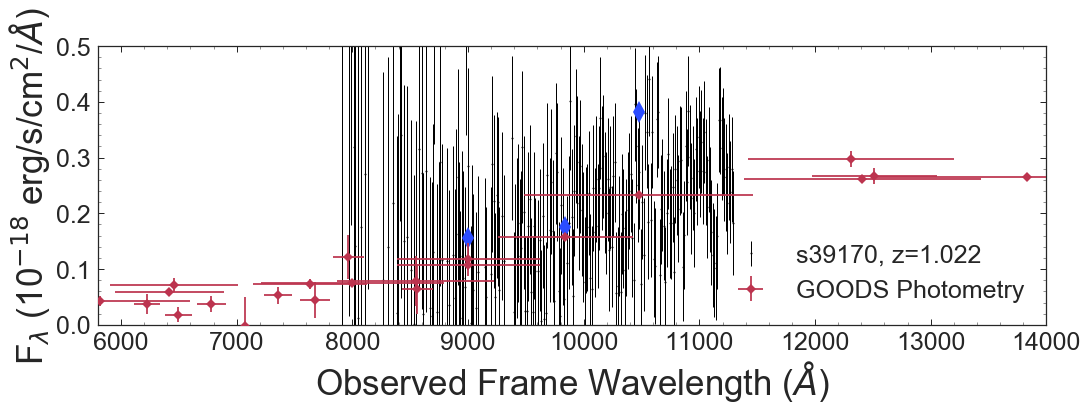

In [12]:
###PLOT
%matplotlib inline    

plt.figure(figsize=[17,6])
plt.errorbar(spec.gal_wv,spec.gal_fl * 1E18,spec.gal_er * 1E18,fmt='o',color = 'k', ms=2,elinewidth=1,label = 's39170, z=1.022')

plt.plot(smpDB['f850-effwv'][236], smpDB['sim-f850'][236] * 1E18,'d',color='#2B4CFF',ms=15)
plt.plot(smpDB['f098-effwv'][236], smpDB['sim-f098'][236] * 1E18,'d',color='#2B4CFF',ms=15)
plt.plot(smpDB['f105-effwv'][236], smpDB['sim-f105'][236] * 1E18,'d',color='#2B4CFF',ms=15)

plt.errorbar(phot_db['eff_wv'],phot_db[galDB['gids'][236]] * Clam *1E18 ,phot_db[galDB['gids'][236] + '_err'] * Clam *1E18,
             phot_db['fwhm']/2 ,color='#BC344F',fmt='D',zorder=5,label='GOODS Photometry')
plt.ylim(0,0.5)
plt.xlim(5800,14000)
plt.minorticks_on()
plt.ylabel('F$_\lambda$ (10$^{-18}$ erg/s/cm$^2$/$\AA$)',size=35)
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel('Observed Frame Wavelength ($\AA$)',size=35)
plt.legend(loc=4,fontsize = 25)
plt.gcf().subplots_adjust(bottom=0.235)
plt.show()
plt.close()

# Age Vs Redshift - 3 feat groups

In [21]:
def Gen_grid(DB,param):
    grid=[]
    for i in DB.index:
        x,Px = np.load('../chidat/%s_dtau_%s_pos_lwa_3.npy' % (DB['gids'][i],param))
        grid.append(Px)
    return np.array(grid)

In [22]:
"""DATA"""
rzoo = importr('zoo')

age_range = np.arange(0,3,0.05)

gmtlDB = galDB.query('ids != 14713 and ids != 38126 and ids != 40597')

Pl_grid = Gen_grid(lzDB,'t')
Pm_grid = Gen_grid(mzDB,'t')
Ph_grid = Gen_grid(hzDB,'t')
Puh_grid = Gen_grid(uhzDB,'t')

Pl = Stack_posteriors(Pl_grid,age)
Pm = Stack_posteriors(Pm_grid,age)
Ph = Stack_posteriors(Ph_grid,age)
Puh = Stack_posteriors(Puh_grid,age)

lmed,ller,lher=Median_w_Error_cont(Pl,age)
mmed,mler,mher=Median_w_Error_cont(Pm,age)
hmed,hler,hher=Median_w_Error_cont(Ph,age)
uhmed,uhler,uhher=Median_w_Error_cont(Puh,age)

lt=np.array(lzDB['tx_lwa'])
mt=np.array(mzDB['tx_lwa'])
ht=np.array(hzDB['tx_lwa'])
uht=np.array(uhzDB['tx_lwa'])
gmtlt=np.array(gmtlDB['tx_lwa'])

fumx,fumy=Readfile('../data/fumagalli_fig14.dat',0)
d,fverr=Readfile('../data/fumagalli_fig14_verr.dat',0)
fherr,d=Readfile('../data/fumagalli_fig14_herr.dat',0)

verr=np.zeros(len(fverr))
herr=np.zeros(len(fherr))
for i in range(len(verr)):
    verr[i]=np.abs(fverr[i]-fumy[i])
    herr[i]=np.abs(fherr[i]-fumx[i])
    
gID,z_g,z_a,redshift,ra,dec,smass,sfr,mWAge,rbWage,metalsSMass = np.loadtxt('../data/millennium2.txt',
                                                                            skiprows=31,delimiter=',').T
mill_DB = pd.DataFrame({'gID':gID,'z_geo':z_g,'z_all':z_a,
                        'redshift':redshift,'ra':ra,'dec':dec,'stellar_mass':smass,'star_formation_rate':sfr,
                       'mass_weighted_age':mWAge,'light_weighted_age':rbWage,'Z_stellar_mass':metalsSMass})
IDW =z_g.argsort()
eres = rzoo.zoo(mill_DB['light_weighted_age'][IDW],mill_DB['z_geo'][IDW])
rmean = rzoo.rollapply(eres,200,'mean', fill = 'NA', align ='right')
rstd = rzoo.rollapply(eres,200,'sd', fill = 'NA', align ='right')

/Users/vestrada/miniconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in add
  after removing the cwd from sys.path.
/Users/vestrada/miniconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in subtract
  """


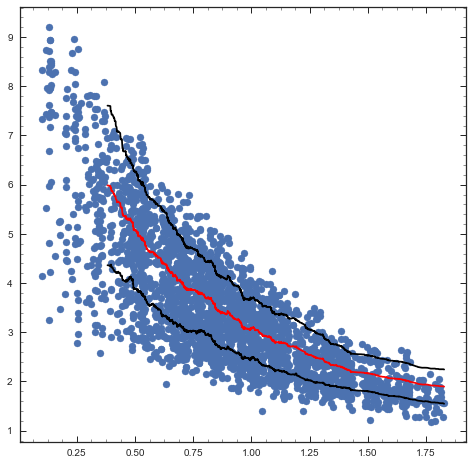

In [23]:
plt.figure(figsize=[8,8])
plt.scatter(z_g[IDW],rbWage)
plt.plot(z_g[IDW],rmean,'r')
plt.plot(z_g[IDW],np.array(rstd) + np.array(rmean),'k')
plt.plot(z_g[IDW],np.array(rmean) - np.array(rstd),'k')

In [17]:
print lmed,ller,lher
print mmed,mler,mher
print hmed,hler,hher
print uhmed,uhler,uhher

3.45390781563 1.03607214429 0.90380761523
2.26352705411 0.749498997996 0.716432865731
2.72645290581 0.661322645291 0.705410821643
1.86673346693 0.683366733467 0.551102204409


/Users/vestrada/miniconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in add
/Users/vestrada/miniconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in subtract
/Users/vestrada/miniconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in subtract
/Users/vestrada/miniconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in add


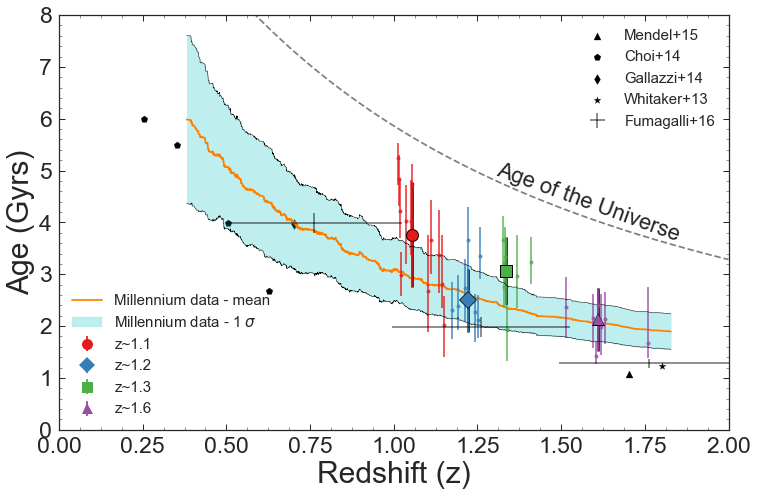

In [51]:
###PLOT
%matplotlib inline

z=np.linspace(0,2,100)
ages=[Oldest_galaxy(a) for a in z]

plt.figure(figsize=[12,8])
currentAxis = plt.gca()
plt.plot(z,ages,'k--',alpha=.5)

ax1=plt.scatter(fumx[9],fumy[9],color = 'k',marker='^')         #,label='Mendel+15')
ax2=plt.scatter(fumx[10:14],fumy[10:14],color = 'k',marker='p') #,label='Choi+14')
ax3=plt.scatter(fumx[14],fumy[14],color = 'k',marker='d')       #,label='Gallazzi+14')
ax4=plt.scatter(fumx[15],fumy[15],color = 'k',marker='*')       #,label='Whitaker+13')
ax5=plt.errorbar(fumx[6:9],fumy[6:9],xerr=herr[6:9],yerr=verr[6:9]
             ,color='k',zorder=3,fmt='o',alpha=.5,ms=1)#,label='Fumagalli+16')

plt.errorbar(lzDB['hi_res_specz'],lt,yerr=[lzDB['tx_-_sig_lwa'],lzDB['tx_+_sig_lwa']],color='#e41a1c',alpha=.8,ms=4,fmt='o')
plt.errorbar(mzDB['hi_res_specz'],mt,yerr=[mzDB['tx_-_sig_lwa'],mzDB['tx_+_sig_lwa']],color='#377eb8',alpha=.8,ms=4,fmt='o')
plt.errorbar(hzDB['hi_res_specz'],ht,yerr=[hzDB['tx_-_sig_lwa'],hzDB['tx_+_sig_lwa']],color='#4daf4a',alpha=.8,ms=4,fmt='o')
plt.errorbar(uhzDB['hi_res_specz'],uht,yerr=[uhzDB['tx_-_sig_lwa'],uhzDB['tx_+_sig_lwa']],color='#984ea3',alpha=.8,ms=4,fmt='o')

plt.errorbar(np.median(lzDB['hi_res_specz']),lmed,yerr=[[ller,lher]], color='k',elinewidth=2.5,ms=13,fmt='o')
plt.errorbar(np.median(mzDB['hi_res_specz']),mmed,yerr=[[mler,mher]], color='k',elinewidth=2.5,ms=13,fmt='D')
plt.errorbar(np.median(hzDB['hi_res_specz']),hmed,yerr=[[hler,hher]], color='k',elinewidth=2.5,ms=13,fmt='s')
plt.errorbar(np.median(uhzDB['hi_res_specz']),uhmed,yerr=[[uhler,uhher]], color='k',elinewidth=2.5,ms=13,fmt='^')


plt.errorbar(np.median(lzDB['hi_res_specz']),lmed,yerr=[[ller,lher]], color='#e41a1c',ms=11,fmt='o',label='z~1.1')
plt.errorbar(np.median(mzDB['hi_res_specz']),mmed,yerr=[[mler,mher]], color='#377eb8',ms=11,fmt='D',label='z~1.2')
plt.errorbar(np.median(hzDB['hi_res_specz']),hmed,yerr=[[hler,hher]], color='#4daf4a',ms=11,fmt='s',label='z~1.3')
plt.errorbar(np.median(uhzDB['hi_res_specz']),uhmed,yerr=[[uhler,uhher]], color='#984ea3',ms=11,fmt='^',label='z~1.6')

plt.plot(z_g[IDW],rmean,color = '#ff7f00',zorder=1,label = 'Millennium data - mean')
plt.plot(z_g[IDW],np.array(rstd) + np.array(rmean),'k',linewidth = .5)
plt.plot(z_g[IDW],np.array(rmean) - np.array(rstd),'k',linewidth = .5)
plt.fill_between(z_g[IDW],np.array(rmean) - np.array(rstd),np.array(rstd) + np.array(rmean),
                color='c',alpha = .25,label = 'Millennium data - 1 $\sigma$')
plt.axis([0.,2.0,0,8])
# plt.axis([0.9,1.8,0,7])
plt.xlabel('Redshift (z)',size=30)
plt.ylabel('Age (Gyrs)',size=30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.text(1.3,4.9,'Age of the Universe',rotation=-20,fontsize=22)
plt.gcf().subplots_adjust(bottom=0.16)
l1= plt.legend([ax1,ax2,ax3,ax4,ax5],['Mendel+15','Choi+14','Gallazzi+14','Whitaker+13','Fumagalli+16'],
              fontsize=15)
plt.legend(loc = 3, fontsize=15)
currentAxis.add_artist(l1)
# plt.show()
plt.savefig('../plots/agevz_featgroup_all_dt_11-5.pdf',bbox_inches = 'tight')
# plt.close()




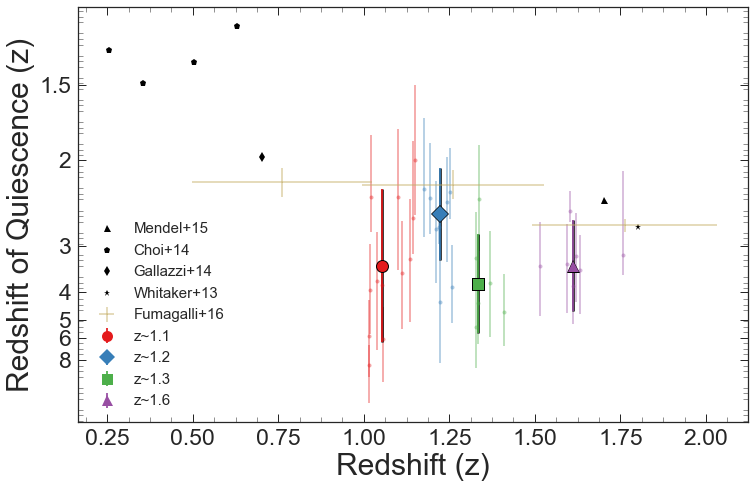

In [83]:
###PLOT
%matplotlib inline

z=np.linspace(0,2,100)
ages=[Oldest_galaxy(a) for a in z]

plt.figure(figsize=[12,8])
currentAxis = plt.gca()
# plt.plot(z,ages,'k--',alpha=.5)

plt.errorbar(fumx[6:9],Oldest_galaxy(fumx[6:9]) - fumy[6:9],xerr=herr[6:9],yerr=verr[6:9]
             ,color=sea.color_palette('muted')[4],zorder=3,fmt='o',alpha=.5,ms=1,label='Fumagalli+16')
plt.plot(fumx[9], Oldest_galaxy(fumx[9]) - fumy[9],'k^',label='Mendel+15')
plt.plot(fumx[10:14],Oldest_galaxy(fumx[10:14]) - fumy[10:14],'kp',label='Choi+14')
plt.plot(fumx[14],Oldest_galaxy(fumx[14]) - fumy[14],'kd',label='Gallazzi+14')
plt.plot(fumx[15],Oldest_galaxy(fumx[15]) - fumy[15],'k*',label='Whitaker+13')

plt.errorbar(lzDB['hi_res_specz'], Oldest_galaxy(lzDB['hi_res_specz']) - lt,
             yerr=[lzDB['tx_-_sig_dt'],lzDB['tx_+_sig_dt']],color='#e41a1c',alpha=.4,ms=4,fmt='o')
plt.errorbar(mzDB['hi_res_specz'],Oldest_galaxy(mzDB['hi_res_specz']) - mt,
             yerr=[mzDB['tx_-_sig_dt'],mzDB['tx_+_sig_dt']],color='#377eb8',alpha=.4,ms=4,fmt='o')
plt.errorbar(hzDB['hi_res_specz'],Oldest_galaxy(hzDB['hi_res_specz']) - ht,
             yerr=[hzDB['tx_-_sig_dt'],hzDB['tx_+_sig_dt']],color='#4daf4a',alpha=.4,ms=4,fmt='o')
plt.errorbar(uhzDB['hi_res_specz'],Oldest_galaxy(uhzDB['hi_res_specz']) - uht,
             yerr=[uhzDB['tx_-_sig_dt'],uhzDB['tx_+_sig_dt']],color='#984ea3',alpha=.4,ms=4,fmt='o')

plt.errorbar(np.median(lzDB['hi_res_specz']), Oldest_galaxy(np.median(lzDB['hi_res_specz'])) - lmed,
             yerr=[[ller,lher]], color='k',ms=13,fmt='o',elinewidth=2.5)
plt.errorbar(np.median(mzDB['hi_res_specz']), Oldest_galaxy(np.median(mzDB['hi_res_specz'])) - mmed,
             yerr=[[mler,mher]], color='k',ms=13,fmt='D',elinewidth=2.5)
plt.errorbar(np.median(hzDB['hi_res_specz']), Oldest_galaxy(np.median(hzDB['hi_res_specz'])) - hmed,
             yerr=[[hler,hher]], color='k',ms=13,fmt='s',elinewidth=2.5)
plt.errorbar(np.median(uhzDB['hi_res_specz']), Oldest_galaxy(np.median(uhzDB['hi_res_specz'])) - uhmed,
             yerr=[[uhler,uhher]], color='k',ms=13,fmt='^',elinewidth=2.5)

plt.errorbar(np.median(lzDB['hi_res_specz']), Oldest_galaxy(np.median(lzDB['hi_res_specz'])) - lmed,
             yerr=[[ller,lher]], color='#e41a1c',ms=11,fmt='o',label='z~1.1')
plt.errorbar(np.median(mzDB['hi_res_specz']), Oldest_galaxy(np.median(mzDB['hi_res_specz'])) - mmed,
             yerr=[[mler,mher]], color='#377eb8',ms=11,fmt='D',label='z~1.2')
plt.errorbar(np.median(hzDB['hi_res_specz']), Oldest_galaxy(np.median(hzDB['hi_res_specz'])) - hmed,
             yerr=[[hler,hher]], color='#4daf4a',ms=11,fmt='s',label='z~1.3')
plt.errorbar(np.median(uhzDB['hi_res_specz']), Oldest_galaxy(np.median(uhzDB['hi_res_specz'])) - uhmed,
             yerr=[[uhler,uhher]], color='#984ea3',ms=11,fmt='^',label='z~1.6')

plt.xlabel('Redshift (z)',size=30)
plt.ylabel('Redshift of Quiescence (z)',size=30)
plt.yticks([0.6389,0.9315,1.1735,1.5413,2.1489,3.2845,4.278],[8,6,5,4,3,2,1.5])
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.gcf().subplots_adjust(bottom=0.16)
# plt.legend(fontsize=23)
plt.legend(loc=3,fontsize=15)
# plt.show()
plt.savefig('../plots/agevz_rshift_all_dt_12-13.pdf',bbox_inches = 'tight')
# plt.close()

In [44]:
rqagel = (Oldest_galaxy(np.median(lzDB['hi_res_specz'])) - age)
rqagem = (Oldest_galaxy(np.median(mzDB['hi_res_specz'])) - age)
rqageh = (Oldest_galaxy(np.median(hzDB['hi_res_specz'])) - age)
rqageuh = (Oldest_galaxy(np.median(uhzDB['hi_res_specz'])) - age)

age_range = np.arange(0,3.5,0.05)

irqPl = interp1d(rqagel,Pl)(age_range) / np.trapz(interp1d(rqagel,Pl)(age_range),age_range)
irqPm = interp1d(rqagem,Pm)(age_range)/ np.trapz(interp1d(rqagem,Pm)(age_range),age_range)
irqPh = interp1d(rqageh,Ph)(age_range)/ np.trapz(interp1d(rqageh,Ph)(age_range),age_range)
irqPuh = interp1d(rqageuh,Puh)(age_range)/ np.trapz(interp1d(rqageuh,Puh)(age_range),age_range)

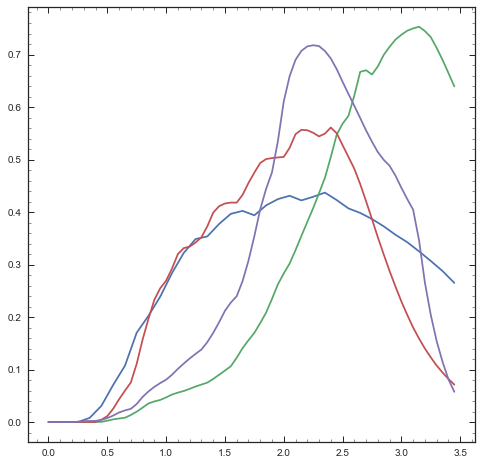

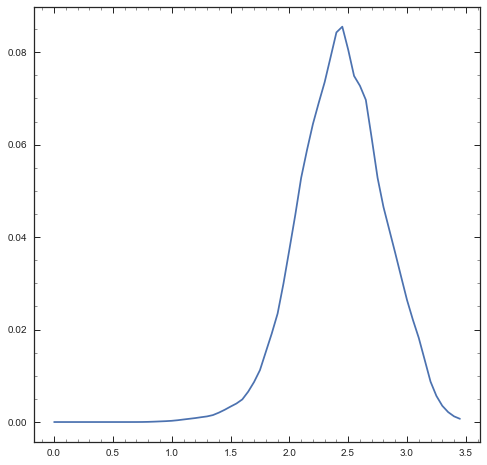

In [45]:
plt.figure(figsize=[8,8])
plt.plot(age_range,irqPl)
plt.plot(age_range,irqPm)
plt.plot(age_range,irqPh)
plt.plot(age_range,irqPuh)

plt.figure(figsize=[8,8])
plt.plot(age_range,irqPl * irqPm * irqPh * irqPuh)

In [ ]:
###PLOT
%matplotlib inline

z=np.linspace(0,2,100)
ages=[Oldest_galaxy(a) for a in z]

plt.figure(figsize=[12,8])
currentAxis = plt.gca()

plt.errorbar(lzDB['hi_res_specz'], Oldest_galaxy(lzDB['hi_res_specz']) - lt,
             yerr=[lzDB['tx_-_sig_dt'],lzDB['tx_+_sig_dt']],color='#e41a1c',alpha=.4,ms=4,fmt='o')
plt.errorbar(mzDB['hi_res_specz'],Oldest_galaxy(mzDB['hi_res_specz']) - mt,
             yerr=[mzDB['tx_-_sig_dt'],mzDB['tx_+_sig_dt']],color='#377eb8',alpha=.4,ms=4,fmt='o')
plt.errorbar(hzDB['hi_res_specz'],Oldest_galaxy(hzDB['hi_res_specz']) - ht,
             yerr=[hzDB['tx_-_sig_dt'],hzDB['tx_+_sig_dt']],color='#4daf4a',alpha=.4,ms=4,fmt='o')
plt.errorbar(uhzDB['hi_res_specz'],Oldest_galaxy(uhzDB['hi_res_specz']) - uht,
             yerr=[uhzDB['tx_-_sig_dt'],uhzDB['tx_+_sig_dt']],color='#984ea3',alpha=.4,ms=4,fmt='o')

plt.errorbar(np.median(lzDB['hi_res_specz']), Oldest_galaxy(np.median(lzDB['hi_res_specz'])) - lmed,
             yerr=[[ller,lher]], color='#e41a1c',ms=11,fmt='o',label='z~1.1')
plt.errorbar(np.median(mzDB['hi_res_specz']), Oldest_galaxy(np.median(mzDB['hi_res_specz'])) - mmed,
             yerr=[[mler,mher]], color='#377eb8',ms=11,fmt='D',label='z~1.2')
plt.errorbar(np.median(hzDB['hi_res_specz']), Oldest_galaxy(np.median(hzDB['hi_res_specz'])) - hmed,
             yerr=[[hler,hher]], color='#4daf4a',ms=11,fmt='s',label='z~1.3')
plt.errorbar(np.median(uhzDB['hi_res_specz']), Oldest_galaxy(np.median(uhzDB['hi_res_specz'])) - uhmed,
             yerr=[[uhler,uhher]], color='#984ea3',ms=11,fmt='^',label='z~1.6')

# plt.axis([0.9,1.7,0,7])
plt.xlabel('Redshift (z)',size=30)
plt.ylabel('Redshift of Quiescence (z)',size=30)
plt.yticks([0.6389,0.76245,0.9315,1.1735,1.5413,2.1489,3.2845,4.278],[8,7,6,5,4,3,2,1.5])
plt.tick_params(axis='both', which='major', labelsize=17)
plt.minorticks_on()
plt.gcf().subplots_adjust(bottom=0.16)
plt.legend(loc=4,fontsize=23)
# plt.show()
plt.savefig('../plots/delta_age_featgroup_dt_9-4.pdf')
plt.close()

In [54]:
# [0.6389,0.76245,0.9315,1.1735,1.5413,2.1489,3.2845,4.278],[8,7,6,5,4,3,2,1.5]

print  Oldest_galaxy(0) * u.Gyr -Planck13.lookback_time(2.6)

2.51193246402 Gyr


#Mass Metallcity - feat group

In [4]:
"""DATA"""
gmtlDB = galDB.query('1.45 > hi_res_specz')
gmtlDB = gmtlDB.query('ids != 14713 and ids != 38126')

Pl_grid = Gen_grid(lzDB,'Z')
Pm_grid = Gen_grid(mzDB,'Z')
Ph_grid = Gen_grid(hzDB,'Z')
Puh_grid = Gen_grid(uhzDB,'Z')

Pl = Stack_posteriors(Pl_grid,metal)
Pm = Stack_posteriors(Pm_grid,metal)
Ph = Stack_posteriors(Ph_grid,metal)
Puh = Stack_posteriors(Puh_grid,metal)

lmed,ller,lher=Median_w_Error_cont(Pl,metal)
mmed,mler,mher=Median_w_Error_cont(Pm,metal)
hmed,hler,hher=Median_w_Error_cont(Ph,metal)
uhmed,uhler,uhher=Median_w_Error_cont(Puh,metal)

logm,gmetal=Readfile('../data/Gallazzi_12.dat',0)
cvx,cvy=Readfile('../data/Gallazzi_12_line.dat',0)
cv1x,cv1y=Readfile('../data/gallazzi_points_curve1.dat',0)

lZ=np.array(lzDB['Zx_lwa'])
mZ=np.array(mzDB['Zx_lwa'])
hZ=np.array(hzDB['Zx_lwa'])
uhZ=np.array(uhzDB['Zx_lwa'])
gmtlZ=np.array(gmtlDB['Zx_lwa'])

lerrs = gmtlDB['Zx_-_sig_lwa']/(gmtlDB['Zx_lwa'] * np.log(10))
herrs = gmtlDB['Zx_+_sig_lwa']/(gmtlDB['Zx_lwa'] * np.log(10))
errs = (gmtlDB['Zx_-_sig_lwa'] + gmtlDB['Zx_+_sig_lwa']/2) / (gmtlDB['Zx_lwa'] * np.log(10))
samp = np.arange(10,11.8,.01)
lfit,lfit_errs = Linear_fit(gmtlDB['lmass'],np.log10(gmtlZ/0.019),errs,samp)

gID,z_g,z_a,redshift,ra,dec,smass,sfr,mWAge,rbWage,metalsSMass = np.loadtxt('../data/millennium2.txt',
                                                                            skiprows=31,delimiter=',').T
mill_DB = pd.DataFrame({'gID':gID,'z_geo':z_g,'z_all':z_a,
                        'redshift':redshift,'ra':ra,'dec':dec,'stellar_mass':smass,'star_formation_rate':sfr,
                       'mass_weighted_age':mWAge,'light_weighted_age':rbWage,'Z_stellar_mass':metalsSMass})
# IDW =z_g.argsort()
# eres = rzoo.zoo(mill_DB['light_weighted_age'][IDW],mill_DB['z_geo'][IDW])
# rmean = rzoo.rollapply(eres,200,'mean', fill = 'NA', align ='right')
# rstd = rzoo.rollapply(eres,200,'sd', fill = 'NA', align ='right')

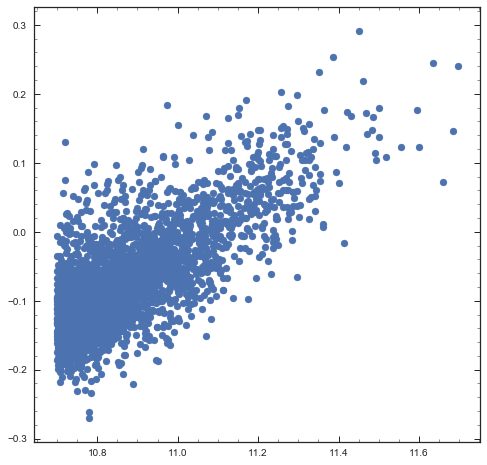

In [9]:
%matplotlib inline

plt.figure(figsize=[8,8])
plt.scatter(np.log10(smass*1E10),np.log10(metalsSMass / smass / .02))

In [70]:
print np.array([lmed,ller,lher])/0.019
print np.array([mmed,mler,mher])/0.019
print np.array([hmed,hler,hher])/0.019
print np.array([uhmed,uhler,uhher])/0.019

[ 0.99419892  0.43117815  0.3780192 ]
[ 0.94103997  0.4843371   0.40755195]
[ 1.02963822  0.29828077  0.32781352]
[ 1.16548887  0.62018774  0.3189537 ]


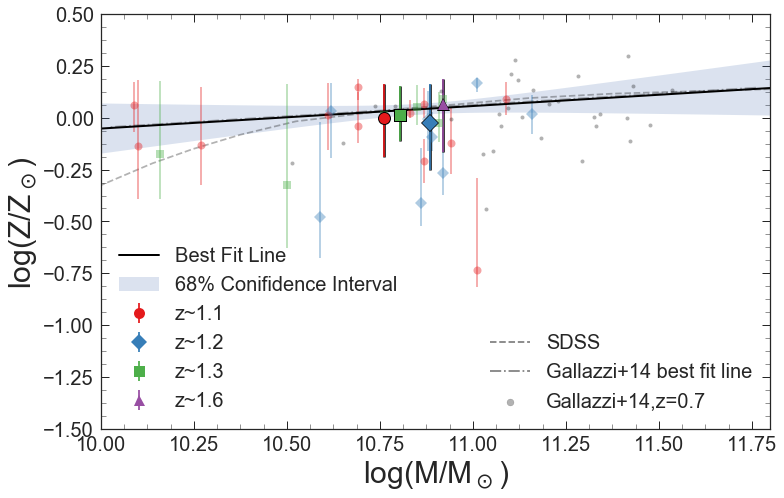

In [74]:
###PLOT
%matplotlib inline

plt.figure(figsize=[12,8])
currentAxis = plt.gca()

####gallazzi points
plt.plot(cv1x,cv1y,'--',zorder=1,color='k',alpha=.3,markersize=4)
sdss=plt.axhline(y=5,linestyle='--',color='k',alpha=.5)
plt.plot(cvx,cvy,zorder=2,linestyle='-.',color='k',alpha=.3,ms=4)
galbf=plt.axhline(y=5,linestyle='-.',color='k',alpha=.5)
plt.plot(logm,gmetal,'o',zorder=3,color='k',alpha=.3,markersize=4)
galpts = plt.scatter(100,100,marker='o',zorder=3,color='k',alpha=.3)#,label='Gallazzi+14,z=0.7')
legend1 = plt.legend([sdss,galbf,galpts],['SDSS','Gallazzi+14 best fit line','Gallazzi+14,z=0.7'],loc = 4,fontsize=20)
currentAxis.add_artist(legend1)
#####single galaxy points
plt.errorbar(lzDB['lmass'],np.log10(lZ/0.019), yerr=[lzDB['Zx_-_sig_dt']/(lzDB['Zx_dt'] * np.log(10)),lzDB['Zx_+_sig_dt']/(lzDB['Zx_dt'] * np.log(10))]
             ,color='#e41a1c',alpha=.4,ms=8,fmt='o')
plt.errorbar(mzDB['lmass'],np.log10(mZ/0.019), yerr=[mzDB['Zx_-_sig_dt']/(mzDB['Zx_dt'] * np.log(10)),mzDB['Zx_+_sig_dt']/(mzDB['Zx_dt'] * np.log(10))]
             ,color='#377eb8',alpha=.4,ms=8,fmt='D')
plt.errorbar(hzDB['lmass'],np.log10(hZ/0.019), yerr=[hzDB['Zx_-_sig_dt']/(hzDB['Zx_dt'] * np.log(10)),hzDB['Zx_+_sig_dt']/(hzDB['Zx_dt'] * np.log(10))]
             ,color='#4daf4a',alpha=.4,ms=8,fmt='s')
plt.plot(samp,lfit,'k',linewidth=2,label ='Best Fit Line')
plt.fill_between(samp,lfit - lfit_errs,lfit + lfit_errs,alpha = .2,label = '68% Conifidence Interval')

plt.errorbar(np.median(lzDB['lmass']),np.log10(lmed/0.019), yerr=[[ller/(lmed * np.log(10))],[lher/(lmed * np.log(10))]],
             color='k',ms=13,fmt='o',elinewidth=2.5)
plt.errorbar(np.median(mzDB['lmass']),np.log10(mmed/0.019),  yerr=[[mler/(mmed * np.log(10))],[mher/(mmed * np.log(10))]],
             color='k',ms=13,fmt='D',elinewidth=2.5)
plt.errorbar(np.median(hzDB['lmass']),np.log10(hmed/0.019),  yerr=[[hler/(hmed * np.log(10))],[hher/(hmed * np.log(10))]],
             color='k',ms=13,fmt='s',elinewidth=2.5)
plt.errorbar(np.median(uhzDB['lmass']),np.log10(uhmed/0.019), yerr=[[uhler/(uhmed * np.log(10))],[uhher/(uhmed * np.log(10))]],
             color='k',ms=13,fmt='^',elinewidth=2.5)

plt.errorbar(np.median(lzDB['lmass']),np.log10(lmed/0.019), yerr=[[ller/(lmed * np.log(10))],[lher/(lmed * np.log(10))]],
             color='#e41a1c',ms=11,fmt='o',label='z~1.1')
plt.errorbar(np.median(mzDB['lmass']),np.log10(mmed/0.019),  yerr=[[mler/(mmed * np.log(10))],[mher/(mmed * np.log(10))]],
             color='#377eb8',ms=11,fmt='D',label='z~1.2')
plt.errorbar(np.median(hzDB['lmass']),np.log10(hmed/0.019),  yerr=[[hler/(hmed * np.log(10))],[hher/(hmed * np.log(10))]],
             color='#4daf4a',ms=11,fmt='s',label='z~1.3')
plt.errorbar(np.median(uhzDB['lmass']),np.log10(uhmed/0.019), yerr=[[uhler/(uhmed * np.log(10))],[uhher/(uhmed * np.log(10))]],
             color='#984ea3',ms=11,fmt='^',label='z~1.6')

plt.xlabel('log(M/M$_\odot$)',size=30)
plt.ylabel('log(Z/Z$_\odot$)',size=30)
plt.axis([10,11.8,-1.5,.5])
plt.tick_params(axis='both', which='major', labelsize=20)
plt.minorticks_on()

plt.gcf().subplots_adjust(bottom=0.16)
plt.legend(fontsize=20)
# plt.show()
plt.savefig('../plots/metalmass_featgroup_12-13.pdf',bbox_inches = 'tight')
# plt.close()

In [106]:
###PLOT
%matplotlib inline
gs = gridspec.GridSpec(2,2,hspace=0.12,wspace=0.05)
plt.figure(figsize=[16,10])
#'#e41a1c' '#377eb8' '#4daf4a' '#984ea3'
#'o','s','D','^'
#### low z
ax1 = plt.subplot(gs[0,0])
plt.plot(cv1x,cv1y,'--',zorder=1,color='k',alpha=.6,markersize=4)
plt.plot(cvx,cvy,zorder=2,color='k',alpha=.6,ms=4)
plt.plot(logm,gmetal,'o',zorder=3,color='k',alpha=.8,markersize=4)
plt.errorbar(lzDB['lmass'],np.log10(lZ/0.019), yerr=np.log10([(lzDB['Zx_f']/(lzDB['Zx_f']-lzDB['Zx_-_sig_f'])),
                            (lzDB['Zx_+_sig_f']/lzDB['Zx_f']+1)]),color='#e41a1c',alpha=1,ms=5,fmt='o')
plt.errorbar(np.median(lzDB['lmass']),np.log10(lmed/0.019), yerr=np.log10([[lmed/(lmed-ller)],[lher/lmed+1]]),
             color='#e41a1c',ms=14,fmt='o',label='z~1.1')
plt.ylabel('log(Z/Z$_\odot$)',size=30)
ax1.xaxis.tick_top()
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
plt.axis([10,11.8,-1.0,.5])
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.gcf().subplots_adjust(bottom=0.16)
plt.legend(fontsize=23)

#### mid z
ax2 = plt.subplot(gs[0,1])
plt.plot(cv1x,cv1y,'--',zorder=1,color='k',alpha=.6,markersize=4)
plt.plot(cvx,cvy,zorder=2,color='k',alpha=.6,ms=4)
plt.plot(logm,gmetal,'o',zorder=3,color='k',alpha=.8,markersize=4)
plt.errorbar(mzDB['lmass'],np.log10(mZ/0.019), yerr=np.log10([(mzDB['Zx_f']/(mzDB['Zx_f']-mzDB['Zx_-_sig_f'])),
                            (mzDB['Zx_+_sig_f']/mzDB['Zx']+1)]),color='#377eb8',alpha=1,ms=5,fmt='o')
plt.errorbar(np.median(mzDB['lmass']),np.log10(mmed/0.019), yerr=np.log10([[mmed/(mmed-mler)],[mher/mmed+1]]),
             color='#377eb8',ms=14,fmt='D',label='z~1.2')
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.yaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')
plt.axis([10,11.8,-1.0,.5])
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.gcf().subplots_adjust(bottom=0.16)
plt.legend(fontsize=23)

#### high z
ax3 = plt.subplot(gs[1,0])
plt.plot(cv1x,cv1y,'--',zorder=1,color='k',alpha=.6,markersize=4)
plt.plot(cvx,cvy,zorder=2,color='k',alpha=.6,ms=4)
plt.plot(logm,gmetal,'o',zorder=3,color='k',alpha=.8,markersize=4)
plt.errorbar(hzDB['lmass'],np.log10(hZ/0.019), yerr=np.log10([(hzDB['Z']/(hzDB['Zx']-hzDB['Zx_-_sig_f'])),
                            (hzDB['Zx_+_sig_f']/hzDB['Zx']+1)]),color='#4daf4a',alpha=1,ms=5,fmt='o')
plt.errorbar(np.median(hzDB['lmass']),np.log10(hmed/0.019), yerr=np.log10([[hmed/(hmed-hler)],[hher/hmed+1]]),
             color='#4daf4a',ms=14,fmt='s',label='z~1.3')
plt.xlabel('log(M/M$_\odot$)',size=30)
plt.ylabel('log(Z/Z$_\odot$)',size=30)
ax3.yaxis.set_ticks_position('both')
ax3.xaxis.set_ticks_position('both')
plt.axis([10,11.8,-1.0,.5])
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.gcf().subplots_adjust(bottom=0.16)
plt.legend(fontsize=23)

#### u high z
ax4 = plt.subplot(gs[1,1])
plt.plot(cv1x,cv1y,'--',zorder=1,color='k',alpha=.6,markersize=4)
plt.plot(cvx,cvy,zorder=2,color='k',alpha=.6,ms=4)
plt.plot(logm,gmetal,'o',zorder=3,color='k',alpha=.8,markersize=4)
plt.errorbar(uhzDB['lmass'],np.log10(uhZ/0.019), yerr=np.log10([(uhzDB['Zx_f']/(uhzDB['Zx_f']-uhzDB['Zx_-_sig_f'])),
                            (uhzDB['Zx_+_sig_f']/uhzDB['Zx_f']+1)]),color='#984ea3',alpha=1,ms=5,fmt='o')
plt.errorbar(np.median(uhzDB['lmass']),np.log10(uhmed/0.019), yerr=np.log10([[uhmed/(uhmed-uhler)],[uhher/uhmed+1]]),
             color='#984ea3',ms=14,fmt='^',label='z~1.6')
plt.xlabel('log(M/M$_\odot$)',size=30)
# plt.ylabel('log(Z/Z$_\odot$)',size=30)
ax4.yaxis.tick_right()
ax4.yaxis.set_ticks_position('both')
ax4.xaxis.set_ticks_position('both')
plt.axis([10,11.8,-1.0,.5])
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.gcf().subplots_adjust(bottom=0.16)
plt.legend(fontsize=23)
# plt.show()
plt.savefig('../plots/metalmass_featgroup_splot_7-20.pdf')
plt.close()

#3 Stack best fits, Feat group

In [75]:
"""DATA"""
lzDB = galDB.query('hi_res_specz < 1.16')
mzDB = galDB.query('1.16 < hi_res_specz < 1.3')
mzDB = mzDB.query('ids != 14713 and ids != 38126')
hzDB = galDB.query('1.3 < hi_res_specz < 1.45')
uhzDB = galDB.query('1.45 < hi_res_specz')

PZl_grid = Gen_grid(lzDB,'Z')
PZm_grid = Gen_grid(mzDB,'Z')
PZh_grid = Gen_grid(hzDB,'Z')
PZuh_grid = Gen_grid(uhzDB,'Z')

PTl_grid = Gen_grid(lzDB,'t')
PTm_grid = Gen_grid(mzDB,'t')
PTh_grid = Gen_grid(hzDB,'t')
PTuh_grid = Gen_grid(uhzDB,'t')

PZl = Stack_posteriors(PZl_grid,metal)
PZm = Stack_posteriors(PZm_grid,metal)
PZh = Stack_posteriors(PZh_grid,metal)
PZuh = Stack_posteriors(PZuh_grid,metal)

PTl = Stack_posteriors(PTl_grid,age)
PTm = Stack_posteriors(PTm_grid,age)
PTh = Stack_posteriors(PTh_grid,age)
PTuh = Stack_posteriors(PTuh_grid,age)


Zmedl, Zler, Zher = Median_w_Error(PZl, metal)
Zmedm, Zler, Zher = Median_w_Error(PZm, metal)
Zmedh, Zler, Zher = Median_w_Error(PZh, metal)
Zmeduh, Zler, Zher = Median_w_Error(PZuh, metal)
tmedl, tler, ther = Median_w_Error(PTl, age)
tmedm, tler, ther = Median_w_Error(PTm, age)
tmedh, tler, ther = Median_w_Error(PTh, age)
tmeduh, tler, ther = Median_w_Error(PTuh, age)

lzstack = Stack(lzDB['gids'].values,lzDB['hi_res_specz'].values,np.arange(3400,5300,10),np.arange(3950,5200,1))
lzstack.Stack_normwmean()
lzstack.Stack_normwmean_model(Zmedl,tmedl,tau)#,bftau=0)

mzstack = Stack(mzDB['gids'].values,mzDB['hi_res_specz'].values,np.arange(3400,5300,10),np.arange(3650,4950,1))
mzstack.Stack_normwmean()
mzstack.Stack_normwmean_model(Zmedm,tmedm,tau)#,bftau=0)

hzstack = Stack(hzDB['gids'].values,hzDB['hi_res_specz'].values,np.arange(3400,5300,10),np.arange(3450,4550,1))
hzstack.Stack_normwmean()
hzstack.Stack_normwmean_model(Zmedh,tmedh,tau)#,bftau=8.3)

uhzstack = Stack(uhzDB['gids'].values,uhzDB['hi_res_specz'].values,np.arange(3300,5300,10),np.arange(3400,4000,1))
uhzstack.Stack_normwmean()
uhzstack.Stack_normwmean_model(Zmeduh,tmeduh,tau)#,bftau=8.0)

../data/galaxy_flts/n16758_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n16758_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n16758_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n16758_flt: save ../data/galaxy_flts/n16758_flt.detect_seg.fits, ../data/galaxy_flts/n16758_flt.detect.cat
../data/galaxy_flts/n19442_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n19442_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n19442_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n19442_flt: save ../data/galaxy_flts/n19442_flt.detect_seg.fits, ../dat

spec_id.py:2651: RuntimeWarning: divide by zero encountered in power
  weigrid = errgrid ** (-2)
spec_id.py:2658: RuntimeWarning: invalid value encountered in double_scalars
  stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / np.sum(weigrid[i])
spec_id.py:2659: RuntimeWarning: divide by zero encountered in double_scalars
  err[i] = 1 / np.sqrt(np.sum(weigrid[i]))


../data/galaxy_flts/n16758_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n16758_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n16758_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n16758_flt: save ../data/galaxy_flts/n16758_flt.detect_seg.fits, ../data/galaxy_flts/n16758_flt.detect.cat
../data/galaxy_flts/n19442_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n19442_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n19442_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n19442_flt: save ../data/galaxy_flts/n19442_flt.detect_seg.fits, ../dat

spec_id.py:567: RuntimeWarning: divide by zero encountered in power
  weigrid = np.array(errgrid).T ** (-2)


../data/galaxy_flts/n16758_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n16758_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n16758_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n16758_flt: save ../data/galaxy_flts/n16758_flt.detect_seg.fits, ../data/galaxy_flts/n16758_flt.detect.cat
../data/galaxy_flts/n19442_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n19442_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n19442_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n19442_flt: save ../data/galaxy_flts/n19442_flt.detect_seg.fits, ../dat

/Users/vestrada/miniconda2/envs/astroconda/lib/python2.7/site-packages/grizli/model.py:1023: RuntimeWarning: invalid value encountered in less
  bad = self.data['SCI'] < sigma*self.data['ERR']


../data/galaxy_flts/s35774_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s35774_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s35774_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s35774_flt: save ../data/galaxy_flts/s35774_flt.detect_seg.fits, ../data/galaxy_flts/s35774_flt.detect.cat
../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../dat

In [78]:
"""PLOT"""
    
def Plot_stack_2(wv,fl,er,mwv,mfl,bfm,bfa,adist,mdist,window=[],group='',save_plot=False,plot_name=''):
    
    gs = gridspec.GridSpec(2,2,hspace=.5,wspace=0,height_ratios=[3,1])
    
    plt.figure(figsize=[15,8])
    plt.subplot(gs[0,0:])
    plt.errorbar(wv,fl * 1000,er * 1000,color='#0571b0',fmt='o',ms = 4,elinewidth=2)
    plt.plot(mwv,mfl * 1000,color='#ca0020',label='Z=%s Z$_\odot$,t=%s' % (np.round(bfm/0.019,2),bfa),zorder = 5,linewidth = 2)
    plt.axvline(3934.777,linestyle='--', alpha=.3)
    plt.axvline(3969.588,linestyle='--', alpha=.3)
    plt.axvline(4102.89,linestyle='--', alpha=.3)
    plt.axvline(4305.61,linestyle='--', alpha=.3)
    plt.axvline(4341.68,linestyle='--', alpha=.3)
    plt.axvline(4862.68,linestyle='--', alpha=.3)
    plt.axvline(5176.7,linestyle='--', alpha=.3)
    plt.axvspan(3910, 3980, color='k', alpha=.1)
    plt.axvspan(3980, 4030, color='k', alpha=.1)
    plt.axvspan(4080, 4120, color='k', alpha=.1)
    plt.axvspan(4250, 4380, color='k', alpha=.1)
    plt.axvspan(4810, 4910, color='k', alpha=.1)
    plt.axvspan(5120, 5240, color='k', alpha=.1)
    plt.text(3900,window[3]+.05,'Ca HK',fontsize=15)
    plt.text(4080,window[3]+.05,'H$\delta$',fontsize=15)
    plt.text(4280,window[3]+.05,'G+H$\gamma$',fontsize=15)
    plt.text(window[0] + 50,window[3] - .15,group,fontsize=25)
    
    if window[1] > 4800:
        plt.text(4830,window[3]+.05,'H$\\beta$',fontsize=15)
    if window[1] > 5100:
        plt.text(5160,window[3]+.05,'Mgb',fontsize=15)
    
    plt.axis(window)
    plt.ylabel('F$_\lambda$',size=20)
    plt.xlabel('Restframe Wavelength ($\AA$)',size=20)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.gcf().subplots_adjust(bottom=0.235)
    plt.legend(loc=4,fontsize=20)
    plt.minorticks_on()
        
    plt.subplot(gs[1,0])
    plt.plot(age,adist,label = 'P(t)')
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.xlim(min(age),max(age))
    plt.xlabel('Age (Gyrs)',size=20)
    plt.yticks([])
    plt.legend(fontsize=15)
    
    plt.subplot(gs[1,1])
    plt.plot(metal,mdist,label = 'P(Z)')
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.xticks([0.00475, 0.0095, 0.01425, 0.019, 0.02375, 0.0285],
           np.round(np.array([0.00475, 0.0095, 0.01425, 0.019, 0.02375, 0.0285])/0.019, 2))    
    plt.xlabel('Metallicity (Z$_\odot$)',size=20)
    plt.xlim(min(metal),max(metal))
    plt.yticks([])
    plt.legend(fontsize=15)
    
    if save_plot == True:
        plt.savefig(plot_name,bbox_inches = 'tight')
    else:
        plt.show()
    plt.close()
    
    
def Plot_stack(wv,fl,er,mwv,mfl,bfm,bfa,adist,mdist,window=[],group='',group_win=[],save_plot=False,plot_name=''):
    
    gs = gridspec.GridSpec(2,2,hspace=0,wspace=0,width_ratios=[3,1])
    
    plt.figure(figsize=[15,7])
    plt.subplot(gs[0:,0])
    plt.errorbar(wv,fl * 1000,er * 1000,color='#0571b0',fmt='o',ms = 4,elinewidth=2)
    plt.plot(mwv,mfl * 1000,color='#ca0020',label='Z=%s Z$_\odot$,t=%s' % (np.round(bfm/0.019,2),bfa),zorder = 5,linewidth = 2)
    plt.axvline(3934.777,linestyle='--', alpha=.3)
    plt.axvline(3969.588,linestyle='--', alpha=.3)
    plt.axvline(4102.89,linestyle='--', alpha=.3)
    plt.axvline(4305.61,linestyle='--', alpha=.3)
    plt.axvline(4341.68,linestyle='--', alpha=.3)
    plt.axvline(4862.68,linestyle='--', alpha=.3)
    plt.axvline(5176.7,linestyle='--', alpha=.3)
    plt.axvspan(3910, 3980, color='k', alpha=.1)
    plt.axvspan(3980, 4030, color='k', alpha=.1)
    plt.axvspan(4080, 4120, color='k', alpha=.1)
    plt.axvspan(4250, 4380, color='k', alpha=.1)
    plt.axvspan(4810, 4910, color='k', alpha=.1)
    plt.axvspan(5120, 5240, color='k', alpha=.1)
    plt.text(3900,window[3]+.05,'Ca HK',fontsize=15)
    plt.text(4080,window[3]+.05,'H$\delta$',fontsize=15)
    plt.text(4280,window[3]+.05,'G+H$\gamma$',fontsize=15)
    plt.text(group_win[0],group_win[1],group,fontsize=25,backgroundcolor=[.3,.3,.3],color='w')
    
    if window[1] > 4800:
        plt.text(4830,window[3]+.05,'H$\\beta$',fontsize=15)
    if window[1] > 5100:
        plt.text(5160,window[3]+.05,'Mgb',fontsize=15)
    
    plt.axis(window)
    plt.ylabel('F$_\lambda$',size=20)
    plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=20)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.gcf().subplots_adjust(bottom=0.235)
    plt.legend(loc=4,fontsize=20)
    plt.minorticks_on()
        
    ax = plt.subplot(gs[0,1])
    plt.plot(age,adist,label = 'P(t)')
    plt.tick_params(axis='both', which='major', labelsize=15)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    plt.xlim(min(age),max(age))
    plt.ylim(0,max(adist))
    plt.xlabel('Age (Gyrs)',size=20)
    plt.yticks([])
    plt.legend(fontsize=15)
    
    plt.subplot(gs[1,1])
    plt.plot(metal,mdist,label = 'P(Z)')
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.xticks([0.00475, 0.0095, 0.01425, 0.019, 0.02375, 0.0285],
           np.round(np.array([0.00475, 0.0095, 0.01425, 0.019, 0.02375, 0.0285])/0.019, 2))    
    plt.xlabel('Metallicity (Z$_\odot$)',size=20)
    plt.xlim(min(metal),max(metal))
    # plt.ylim(0,max(mdist))
    plt.yticks([])
    plt.legend(fontsize=15)
    
    if save_plot == True:
        plt.savefig(plot_name,bbox_inches = 'tight')
    else:
        plt.show()
    plt.close()

In [77]:
print lzstack.bfmetal,lzstack.bfage, lzstack.bftau
print mzstack.bfmetal,mzstack.bfage, mzstack.bftau
print hzstack.bfmetal,hzstack.bfage, hzstack.bftau
print uhzstack.bfmetal,uhzstack.bfage, uhzstack.bftau

0.019 3.8 0
0.018 2.5 8.3
0.02 3.1 8.48
0.023 2.2 8.3


In [79]:
%matplotlib inline

Plot_stack(lzstack.wv,lzstack.fl,lzstack.er,lzstack.mwv,lzstack.mfl,0.019,3.8,PTl,PZl,
           window=[3800,5300,.2,1.],group='z~1.1',group_win=[3850,0.9],save_plot=True,
           plot_name='../plots/stack_lz_bf_12-13.pdf')

Plot_stack(mzstack.wv,mzstack.fl,mzstack.er,mzstack.mwv,mzstack.mfl,0.018,2.5,PTm,PZm,
           window=[3500,5100,0,1.],group='z~1.2',group_win=[3550,0.85],save_plot=True,
           plot_name='../plots/stack_mz_bf_12-13.pdf')

Plot_stack(hzstack.wv,hzstack.fl,hzstack.er,hzstack.mwv,hzstack.mfl,0.02,3.1,PTh,PZh,
           window=[3400,4790,0,1.6],group='z~1.3',group_win=[3450,1.4],save_plot=True,
           plot_name='../plots/stack_hz_bf_12-13.pdf')

Plot_stack(uhzstack.wv,uhzstack.fl,uhzstack.er,uhzstack.mwv,uhzstack.mfl,0.023,2.2,PTuh,PZuh,
           window=[3300,4390,0.5,4.2],group='z~1.6',group_win=[3340,3.6],save_plot=True,
           plot_name='../plots/stack_uhz_bf_12-13.pdf')

# Fitting Technique Compare

In [3]:
"""DATA"""
mp = [0.005,0.007,0.011,0.013,0.017,0.019,0.021,0.023,0.025,0.027,]
ap = [3.2,2.2,3.8,2.7,4.4,3.2,1.9,5.2,3.6,2.0]

mwc,awc = np.array([[],[]])
mnc,anc = np.array([[],[]])

for i in range(len(mp)):
    mdf1,adf1 = np.load('../mcerr/s39170_m%s_a%s_meth.npy' % (mp[i],ap[i]))
    mwc = np.append(mwc,mdf1 - mp[i])
    awc = np.append(awc,adf1 - ap[i])
    
    mdf1,adf1 = np.load('../mcerr/n21156_m%s_a%s_meth.npy' % (mp[i],ap[i]))
    mwc = np.append(mwc,mdf1 - mp[i])
    awc = np.append(awc,adf1 - ap[i])
    
    mdf1,adf1 = np.load('../mcerr/s40862_m%s_a%s_meth.npy' % (mp[i],ap[i]))
    mwc = np.append(mwc,mdf1 - mp[i])
    awc = np.append(awc,adf1 - ap[i])
    
    mdf1,adf1 = np.load('../mcerr/s44042_m%s_a%s_meth.npy' % (mp[i],ap[i]))
    mwc = np.append(mwc,mdf1 - mp[i])
    awc = np.append(awc,adf1 - ap[i])
    
    mdf1,adf1 = np.load('../mcerr/s39170_m%s_a%s_methNC.npy' % (mp[i],ap[i]))
    mnc = np.append(mnc,mdf1 - mp[i])
    anc = np.append(anc,adf1 - ap[i])
    
    mdf1,adf1 = np.load('../mcerr/n21156_m%s_a%s_methNC.npy' % (mp[i],ap[i]))
    mnc = np.append(mnc,mdf1 - mp[i])
    anc = np.append(anc,adf1 - ap[i])
    
    mdf1,adf1 = np.load('../mcerr/s40862_m%s_a%s_methNC.npy' % (mp[i],ap[i]))
    mnc = np.append(mnc,mdf1 - mp[i])
    anc = np.append(anc,adf1 - ap[i])
    
    mdf1,adf1 = np.load('../mcerr/s44042_m%s_a%s_methNC.npy' % (mp[i],ap[i]))
    mnc = np.append(mnc,mdf1 - mp[i])
    anc = np.append(anc,adf1 - ap[i])

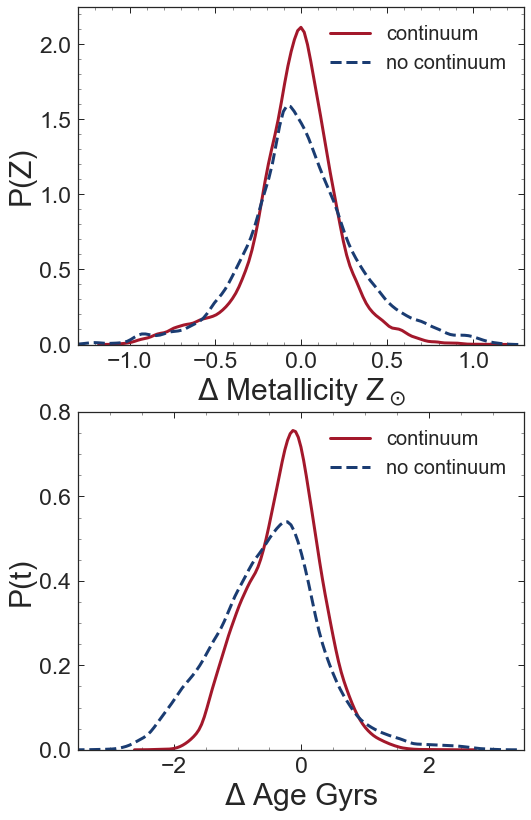

In [36]:
"""PLOT"""
%matplotlib inline

gs = gridspec.GridSpec(2,1)

plt.figure(figsize=[8,16])
plt.subplot(gs[0])
sea.distplot(mwc/0.019,hist=False,kde_kws={ "lw": 3},color = '#A3182B',label='continuum')
sea.distplot(mnc/0.019,hist=False,kde_kws={ "lw": 3,'ls':'--'},color = '#1A3C72',label='no continuum')
plt.xlabel('$\Delta$ Metallicity Z$_\odot$',fontsize = 30)
plt.ylabel('P(Z)',fontsize = 30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.gcf().subplots_adjust(bottom=0.235)
plt.legend(fontsize=20)
plt.ylim(0,2.25)
plt.xlim(-1.3,1.3)
plt.minorticks_on()

# plt.figure(figsize=[8,8])
plt.subplot(gs[1])
sea.distplot(awc,hist=False,kde_kws={ "lw": 3},color = '#A3182B',label='continuum')
sea.distplot(anc,hist=False,kde_kws={ "lw": 3,'ls':'--'},color = '#1A3C72',label='no continuum')
plt.xlabel('$\Delta$ Age Gyrs',fontsize = 30)
plt.ylabel('P(t)',fontsize = 30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.gcf().subplots_adjust(bottom=0.235)
plt.legend(fontsize=20)
plt.ylim(0,.8)
plt.xlim(-3.5,3.5)
plt.minorticks_on()
# plt.show()
plt.savefig('../plots/P-Zt_2cases.pdf',bbox_inches = 'tight')
# plt.close()

#Fitting Technique Compare - Likelihoods

In [102]:
"""DATA"""
tmlist,talist = np.load('../mcerr/s44042_m0.019_a4.5.npy')
ncmlist,ncalist = np.load('../mcerr/s44042_m0.019_a4.5NC.npy')

In [103]:
"""PLOTS""" # same data as above
%matplotlib inline
colmap = sea.cubehelix_palette(12, start=3, rot=0.5, dark=0.1, light=.5, as_cmap=True)

Mlist =np.array([ncmlist,tmlist])
Alist = np.array([ncalist,talist])
pltnames = ['nc_LH.png','t_LH.png']

for i in range(len(Mlist)):
    plt.figure(figsize=[10,8])
    plt.plot(Mlist[i]/.019,Alist[i],'o',alpha=.3,ms=4)
    sea.kdeplot(Mlist[i]/.019,Alist[i],n_levels=2,cmap=colmap)
    plt.plot(0.019/.019,4.5,'rp',ms=10,label='Given parameters')
    plt.axis([0.0/.019,.03/.019,0,6])
    plt.xlabel('Metallicity (Z/Z$_\odot$)',fontsize = 30)
    plt.ylabel('Age (Gyr)',fontsize = 30)
    # plt.title('Continuum',fontsize = 20)
    plt.tick_params(axis='both', which='major', labelsize=23)
    plt.legend(loc=4,fontsize=23)
    plt.minorticks_on()
    # plt.show()
    plt.savefig('../plots/' + pltnames[i])
    plt.close()

# Redshift group comparison

In [37]:
"""DATA"""
mp = np.arange(0.005,0.029,0.002)
ap = [3.2,2.2,1.0,3.8,2.7,1.4,4.4,3.2,1.9,5.2,3.6,2.0]

ms39,as39 = np.array([[],[]])
mn21,an21 = np.array([[],[]])
ms40,as40 = np.array([[],[]])
ms44,as44 = np.array([[],[]])


for i in range(len(mp)):
    mdf1,adf1 = np.load('../mcerr/MC_s39170-m%s_a%s_lwa.npy' % (mp[i],ap[i]))
    ms39 = np.append(ms39,mdf1 - mp[i])
    as39 = np.append(as39,adf1 - ap[i])
    
    mdf1,adf1 = np.load('../mcerr/MC_n21156-m%s_a%s_lwa.npy' % (mp[i],ap[i]))
    mn21 = np.append(mn21,mdf1 - mp[i])
    an21 = np.append(an21,adf1 - ap[i])
    
    mdf1,adf1 = np.load('../mcerr/MC_s40862-m%s_a%s_lwa.npy' % (mp[i],ap[i]))
    ms40 = np.append(ms40,mdf1 - mp[i])
    as40 = np.append(as40,adf1 - ap[i])
    
    mdf1,adf1 = np.load('../mcerr/MC_s44042-m%s_a%s_lwa.npy' % (mp[i],ap[i]))
    ms44 = np.append(ms44,mdf1 - mp[i])
    as44 = np.append(as44,adf1 - ap[i])

In [6]:
print np.median(ms39/.019)
print np.median(mn21/.019)
print np.median(ms40/.019)
print np.median(ms44/.019)

print np.median(as39)
print np.median(an21)
print np.median(as40)
print np.median(as44)

-0.0258411559962
-0.00516823119924
-0.0176141757199
-0.00485180888092
0.0617234468938
-0.00561122244489
0.231863727455
-0.00721442885772


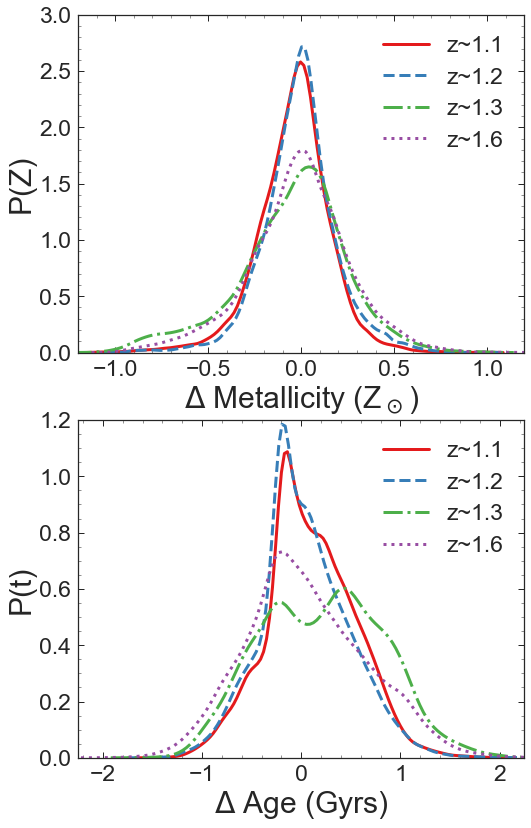

In [43]:
"""PLOT"""
%matplotlib inline
gs = gridspec.GridSpec(2,1)
plt.figure(figsize=[8,16])
plt.subplot(gs[0])
sea.distplot(ms39/.019,color='#e41a1c',kde_kws={ "lw": 3},hist=False,label='z~1.1')
sea.distplot(mn21/.019,color='#377eb8',kde_kws={ "lw": 3,'ls':'--'},hist=False,label='z~1.2')
sea.distplot(ms40/.019,color='#4daf4a',kde_kws={ "lw": 3,'ls':'-.'},hist=False,label='z~1.3')
sea.distplot(ms44/.019,color='#984ea3',kde_kws={ "lw": 3,'ls':':'},hist=False,label='z~1.6')
plt.xlabel('$\Delta$ Metallicity (Z$_\odot$)',fontsize = 30)
plt.ylabel('P(Z)',fontsize = 30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.gcf().subplots_adjust(bottom=0.235)
plt.legend(fontsize=23)
plt.ylim(0,3)
plt.xlim(-1.2,1.2)

plt.subplot(gs[1])
sea.distplot(as39,color='#e41a1c',hist=False,kde_kws={ "lw": 3},label='z~1.1')
sea.distplot(an21,color='#377eb8',hist=False,kde_kws={ "lw": 3,'ls':'--'},label='z~1.2')
sea.distplot(as40,color='#4daf4a',hist=False,kde_kws={ "lw": 3,'ls':'-.'},label='z~1.3')
sea.distplot(as44,color='#984ea3',hist=False,kde_kws={ "lw": 3,'ls':':'},label='z~1.6')
plt.xlabel('$\Delta$ Age (Gyrs)',fontsize = 30)
plt.ylabel('P(t)',fontsize = 30)
plt.tick_params(axis='both', which='major', labelsize=23)
# plt.gcf().subplots_adjust(bottom=0.235)
plt.legend(fontsize=23)
plt.ylim(0,1.2)
plt.xlim(-2.25,2.25)
# plt.show()
plt.savefig('../plots/groups_Zt.pdf',bbox_inches = 'tight')
# plt.close()

# Data plot

In [3]:
%matplotlib inline

img1=fits.open('../../../Clear_data/extractions_nov_22/ERSPRIME/ERSPRIME-19-122-G102_39170.2D.fits')
img2=fits.open('../../../Clear_data/extractions_nov_22/ERSPRIME/ERSPRIME-21-092-G102_39170.2D.fits')
img3=fits.open('../../../Clear_data/extractions_nov_22/ERSPRIME/ERSPRIME-22-142-G102_39170.2D.fits')

print img1.info()

Filename: ../../../Clear_data/extractions_nov_22/ERSPRIME/ERSPRIME-19-122-G102_39170.2D.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU      36   ()      
  1  DSCI        ImageHDU        51   (36, 36)   float64   
  2  DINTER      ImageHDU        51   (36, 36)   float64   
  3  DWHT        ImageHDU        51   (36, 36)   float32   
  4  DSEG        ImageHDU        51   (36, 36)   int32   
  5  SCI         ImageHDU        52   (360, 36)   float64   
  6  WHT         ImageHDU        53   (360, 36)   float64   
  7  MODEL       ImageHDU        53   (360, 36)   float64   
  8  CONTAM      ImageHDU        53   (360, 36)   float64   
  9  WAVE        ImageHDU        52   (360,)   float64   
 10  SENS        ImageHDU        53   (360,)   float64   
 11  YTRACE      ImageHDU        53   (360,)   float64   
None


In [ ]:
field.info()

Filename: ../../Grizlsim/s39170_cmb_flt.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU     282   ()              
1    SCI         ImageHDU        58   (1614, 1614)   float32   
2    ERR         ImageHDU        58   (1614, 1614)   float32   
3    DQ          ImageHDU        58   (1614, 1614)   int64   


In [96]:
%matplotlib inline

# plt.figure(figsize=[12,4])
plt.imshow(np.arcsinh(img1['DSCI'].data[::-1]),vmin = 0)
# plt.imshow(np.arcsinh(img1['SCI'].data[::-1,60:330] - img1['CONTAM'].data[::-1,60:330]),vmin = 0)
plt.yticks([])
plt.xticks([])
plt.savefig('../plots/s39170_dir1.eps',format = 'eps',dpi = 72)
# plt.show()
plt.close()

# plt.figure(figsize=[12,4])
plt.imshow(np.arcsinh(img2['DSCI'].data[::-1]),vmin = 0)
# plt.imshow(np.arcsinh((img2['SCI'].data[::-1,60:330] - img2['CONTAM'].data[::-1,60:330])),vmin = 0)
plt.yticks([])
plt.xticks([])
plt.savefig('../plots/s39170_dir2.eps',format = 'eps',dpi = 72)
# plt.show()
plt.close()
# 
# plt.figure(figsize=[12,4])
plt.imshow(np.arcsinh(img3['DSCI'].data[::-1]),vmin = 0)
# plt.imshow(np.arcsinh((img3['SCI'].data[::-1,60:330] - img3['CONTAM'].data[::-1,60:330])),vmin = 0)
plt.yticks([])
plt.xticks([])
plt.savefig('../plots/s39170_dir3.eps',format = 'eps',dpi = 72)
# plt.show()
plt.close()

# 2D fit example

In [3]:
#DATA

img1=fits.open('../../../Clear_data/extractions_nov_22/ERSPRIME/ERSPRIME-19-122-G102_39170.2D.fits')
# img2=fits.open('../../../Clear_data/extractions_nov_22/ERSPRIME/ERSPRIME-21-092-G102_39170.2D.fits')
# img3=fits.open('../../../Clear_data/extractions_nov_22/ERSPRIME/ERSPRIME-22-142-G102_39170.2D.fits')

spec = Gen_spec('s39170', 1.022)
spec.Sim_spec(galDB['Z_lwa'][220],galDB['t_lwa'][220],8.0, gen_2d =True)

# print img1.info()

No TEAL-based tasks available for this package!
../data/galaxy_flts/s39170_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39170_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39170_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39170_flt: save ../data/galaxy_flts/s39170_flt.detect_seg.fits, ../data/galaxy_flts/s39170_flt.detect.cat


/Users/vestrada/miniconda2/envs/astroconda/lib/python2.7/site-packages/grizli/model.py:496: RuntimeWarning: invalid value encountered in divide
  self.optimal_profile = m/m.sum(axis=0)


In [22]:
#readjust
modelw = spec.model_w
modelh = np.arange(spec.beam.beam.sh_beam[0])
imgw = img1['WAVE'].data
imgh = np.arange(img1['SCI'].data.shape[0])

adj_model = interp2d(modelw,modelh,spec.model_2d)(imgw,modelh)           
# cframe = interp2d(metal, scale[ii], Cchi[ii])(metal, age[:-overhead[ii]])



In [31]:
print modelh.size
print imgh.size

52
36


In [37]:
adj = np.max(img1['SCI'].data)/np.max(adj_model[8:-8,:])

In [40]:
np.max(adj_model[8:-8,:]*adj)

0.11742242620221079

([], <a list of 0 Text xticklabel objects>)

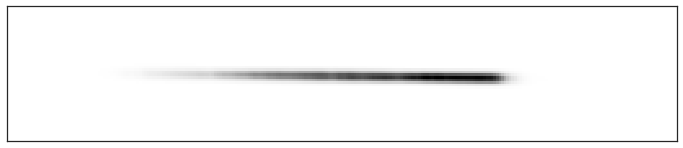

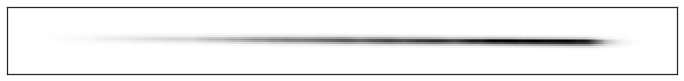

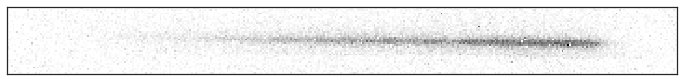

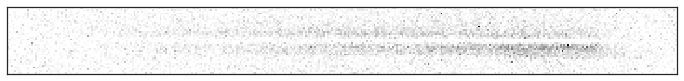

In [97]:
#plot
%matplotlib inline

plt.figure(figsize=[12,4])
plt.imshow(spec.model_2d)
plt.yticks([])
plt.xticks([])

plt.figure(figsize=[12,4])
plt.imshow(adj_model[9:-7,:])
plt.yticks([])
plt.xticks([])

plt.figure(figsize=[12,4])
plt.imshow(np.arcsinh(img1['SCI'].data - img1['CONTAM'].data),vmin = 0)
plt.yticks([])
plt.xticks([])

plt.figure(figsize=[12,4])
plt.imshow(img1['SCI'].data - img1['CONTAM'].data - adj_model[9:-7,:]*adj*.6,vmin = 0)
plt.yticks([])
plt.xticks([])



In [69]:
model_mid = np.array(adj_model[9:-7,:]*adj).T[200]
img_mid = np.array(img1['SCI'].data - img1['CONTAM'].data).T[200]

In [95]:
m_stds = np.zeros(imgw.size)
i_stds = np.zeros(imgw.size)
for i in range(len(imgw)):
    m_stds[i] = np.std(np.array(adj_model[9:-7,:]*adj*.6).T[i])
    i_stds[i] = np.std(np.array(img1['SCI'].data - img1['CONTAM'].data).T[i])
    
m_max = np.zeros(imgw.size)
i_max = np.zeros(imgw.size)
for i in range(len(imgw)):
    m_max[i] = np.max(np.array(adj_model[9:-7,:]*adj*.6).T[i])
    i_max[i] = np.max(np.array(img1['SCI'].data - img1['CONTAM'].data).T[i])

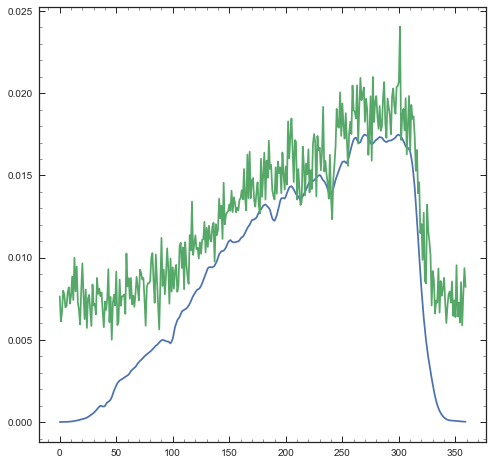

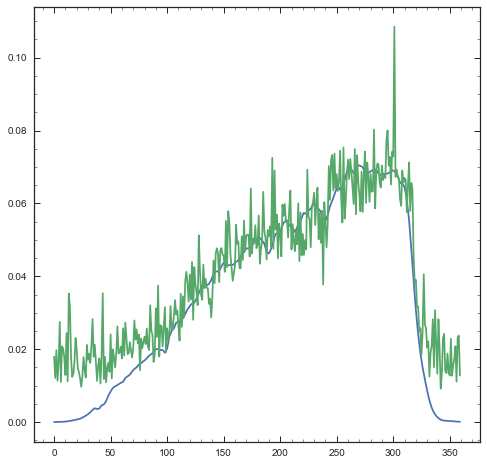

In [96]:
plt.figure(figsize=[8,8])
plt.plot(m_stds)
plt.plot(i_stds)

plt.figure(figsize=[8,8])
plt.plot(m_max)
plt.plot(i_max)

# Photometry plots

In [151]:
###DATA
smpDB = pd.read_pickle('../data/sim_meas_phot.pkl')
smpDB = smpDB[smpDB['gal_ids'] != 's35774']
f098DB = smpDB[smpDB['meas-f098'] > 0]
f850DB = smpDB[smpDB['meas-f850'] > 0]
f105DB = smpDB[smpDB['meas-f105'] > 0]

def Magnitude(flam):
    mag=-2.5*np.log10(flam)
    return mag

Clam = 3E18 / 10475.92199 **2 * 10**((-1.1)/2.5-29)

SNr = []

for i in f098DB.index:
    spec = Gen_spec(f098DB['gal_ids'][i], float(galDB['hi_res_specz'][galDB['gids'] == f098DB['gal_ids'][i]]),maxwv=11400)
    fl = np.trapz(spec.gal_fl,spec.gal_wv)
    er = np.trapz(spec.gal_er,spec.gal_wv)
    SNr.append(fl/er)

../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat
../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39012_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39012_flt: photutils.source_properties - 5 objects
../data/galaxy_flts/s39012_flt: save ../data/galaxy_flts/s39012_flt.detect_seg.fits, ../dat

In [66]:
print -25-Magnitude(f105DB['meas-f105']/Clam)
# print len(Magnitude(f105DB['sim-f105']/f105DB['meas-f105']))

43    -22.5448
49    -21.5979
50    -21.6091
58    -23.3542
61    -21.3358
62    -22.5669
69    -22.8938
86    -22.1206
96    -21.2878
107   -21.8053
110   -22.6226
217   -21.8646
219   -23.3462
220   -20.6981
221   -21.2453
223   -21.7477
224   -22.1838
225   -23.0049
227   -23.4668
228   -22.4279
230   -21.3022
231   -22.9147
232   -22.2341
234   -23.1320
235   -22.9333
236   -24.0746
246   -22.1832
248   -22.5803
251   -22.4997
258   -21.4281
259   -22.3644
260   -23.6325
267   -22.9648
270   -21.5716
Name: meas-f105, dtype: float64


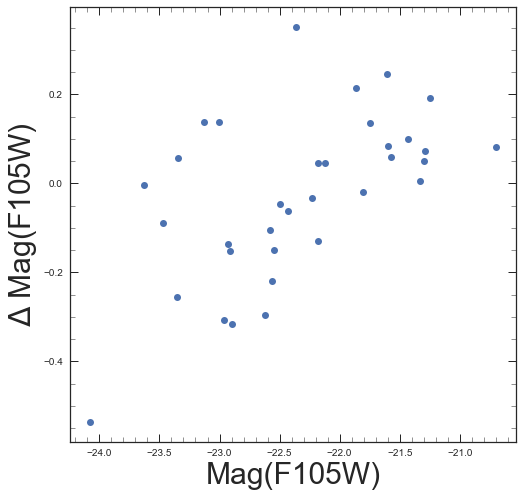

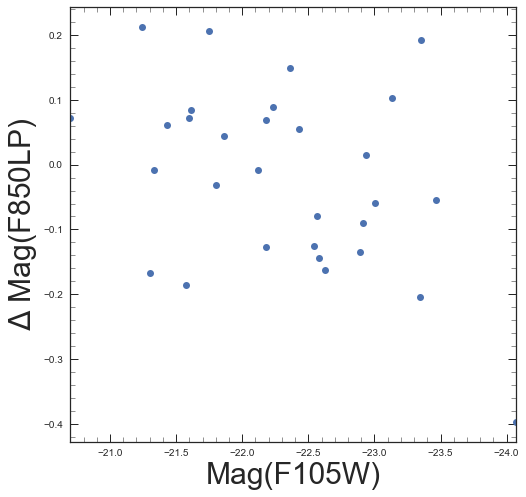

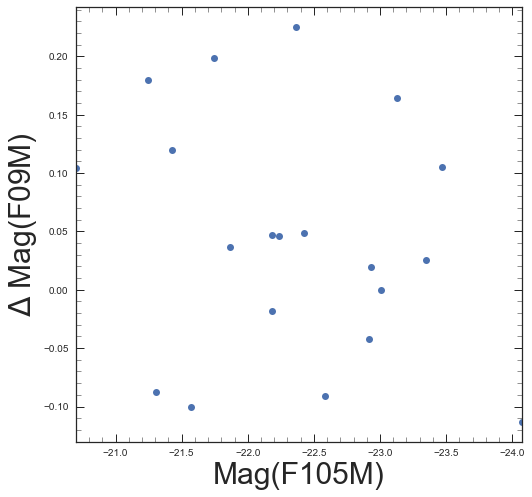

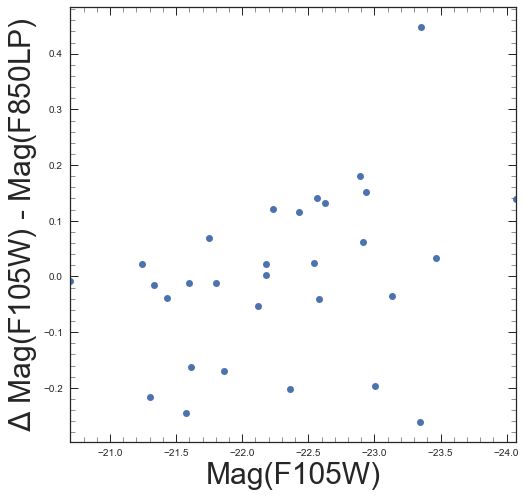

In [148]:
###PLOT 
%matplotlib inline

plt.figure(figsize=[8,8])
plt.plot(-25-Magnitude(f105DB['meas-f105']/Clam),Magnitude(f105DB['sim-f105']/f105DB['meas-f105']),'o')
plt.ylabel('$\Delta$ Mag(F105W)',fontsize = 30)
plt.xlabel('Mag(F105W)',fontsize = 30)
# plt.xlim(max(-25-Magnitude(smpDB['meas-f105']/Clam)),min(-25-Magnitude(smpDB['meas-f105']/Clam)))
plt.show()
# plt.savefig('../plots/df105.png')
plt.close()

plt.figure(figsize=[8,8])
plt.plot(-25-Magnitude(f850DB['meas-f105']/Clam),Magnitude(f850DB['sim-f850']/f850DB['meas-f850']),'o')
plt.ylabel('$\Delta$ Mag(F850LP)',fontsize = 30)
plt.xlabel('Mag(F105W)',fontsize = 30)
plt.xlim(max(-25-Magnitude(smpDB['meas-f105']/Clam)),min(-25-Magnitude(smpDB['meas-f105']/Clam)))
plt.show()
# plt.savefig('../plots/df850.png')
plt.close()

plt.figure(figsize=[8,8])
plt.plot(-25-Magnitude(f098DB['meas-f105']/Clam),Magnitude(f098DB['sim-f098']/f098DB['meas-f098']),'o')
plt.ylabel('$\Delta$ Mag(F09M)',fontsize = 30)
plt.xlabel('Mag(F105M)',fontsize = 30)
plt.xlim(max(-25-Magnitude(smpDB['meas-f105']/Clam)),min(-25-Magnitude(smpDB['meas-f105']/Clam)))
plt.show()
# plt.savefig('../plots/df098.png')
plt.close()

plt.figure(figsize=[8,8])
plt.plot(-25-Magnitude(f850DB['meas-f105']/Clam),Magnitude((f850DB['sim-f850']*f850DB['meas-f105'])/(f850DB['meas-f850']*f850DB['sim-f105'])),'o')
plt.ylabel('$\Delta$ Mag(F105W) - Mag(F850LP)',fontsize = 30)
plt.xlabel('Mag(F105W)',fontsize = 30)
plt.xlim(max(-25-Magnitude(smpDB['meas-f105']/Clam)),min(-25-Magnitude(smpDB['meas-f105']/Clam)))
plt.show()
# plt.savefig('../plots/df105_f850.png')
plt.close()

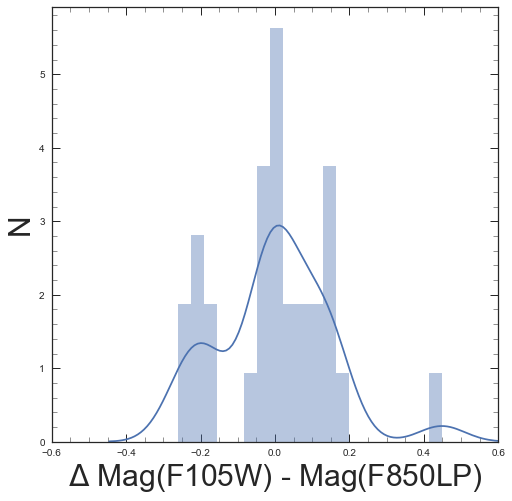

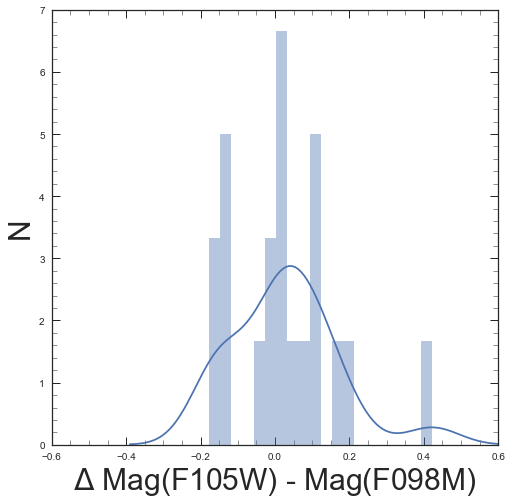

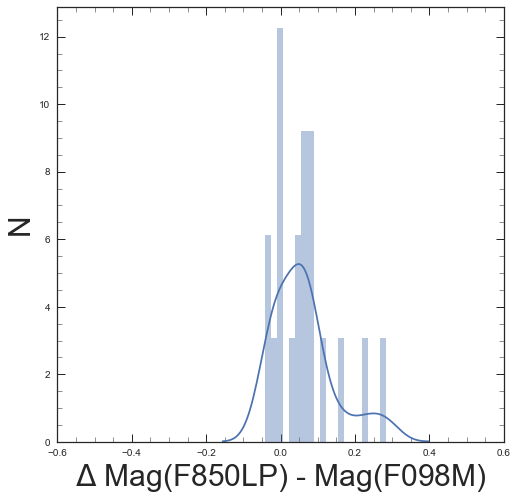

In [147]:
###PLOT 
%matplotlib inline

plt.figure(figsize=[8,8])
sea.distplot(Magnitude((f850DB['sim-f850']*f850DB['meas-f105'])/(f850DB['meas-f850']*f850DB['sim-f105'])),20)
plt.xlabel('$\Delta$ Mag(F105W) - Mag(F850LP)',fontsize = 30)
plt.ylabel('N',fontsize = 30)
plt.xlim(-.6,.6)
plt.show()
# plt.savefig('../plots/df105_850_dist.png')
plt.close()

plt.figure(figsize=[8,8])
sea.distplot(Magnitude((f098DB['sim-f098']*f098DB['meas-f105'])/(f098DB['meas-f098']*f098DB['sim-f105'])),20)
plt.xlabel('$\Delta$ Mag(F105W) - Mag(F098M)',fontsize = 30)
plt.ylabel('N',fontsize = 30)
plt.xlim(-.6,.6)
plt.show()
# plt.savefig('../plots/df105_f098_dist.png')
plt.close()

plt.figure(figsize=[8,8])
sea.distplot(Magnitude((f098DB['sim-f098']*f098DB['meas-f850'])/(f098DB['meas-f098']*f098DB['sim-f850'])),20)
plt.xlabel('$\Delta$ Mag(F850LP) - Mag(F098M)',fontsize = 30)
plt.ylabel('N',fontsize = 30)
plt.xlim(-.6,.6)
plt.show()
# plt.savefig('../plots/df850_f098_dist.png')
plt.close()

In [157]:
###PLOT 
%matplotlib inline


plt.figure(figsize=[8,8])
plt.plot(SNr,Magnitude((f098DB['sim-f098']*f098DB['meas-f850'])/(f098DB['meas-f098']*f098DB['sim-f850'])),'o')
# plt.axhline(medr,color = 'r')
# plt.axhline(medr-mlerrr,color = 'k')
# plt.axhline(medr+mherrr,color = 'k')
plt.ylabel('$\Delta$ (Mag(F098M) - Mag(F850LP))',fontsize = 30)
plt.xlabel('Integrated SN',fontsize = 30)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.gcf().subplots_adjust(left=0.15)
# plt.show()
plt.savefig('../plots/d_f098_f850.pdf')
plt.close()

In [150]:
f098DB.columns

Index([u'f098-effwv', u'f105-effwv', u'f850-effwv', u'gal_ids', u'meas-f098',
       u'meas-f098_err', u'meas-f105', u'meas-f105_err', u'meas-f850',
       u'meas-f850_err', u'sim-f098', u'sim-f098_err', u'sim-f105',
       u'sim-f105_err', u'sim-f850', u'sim-f850_err'],
      dtype='object')